# Boundary Conditions at a Spherical Interface

Maxwell's equations require interface continuity conditions (assuming no free surface charge/current):

$$
\hat{n} \times (\mathbf{E}_{\mathrm{out}} - \mathbf{E}_{\mathrm{in}})=0,
\qquad
\hat{n} \cdot (\mathbf{D}_{\mathrm{out}} - \mathbf{D}_{\mathrm{in}})=0,
$$

$$
\hat{n} \times (\mathbf{H}_{\mathrm{out}} - \mathbf{H}_{\mathrm{in}})=0,
\qquad
\hat{n} \cdot (\mathbf{B}_{\mathrm{out}} - \mathbf{B}_{\mathrm{in}})=0.
$$

For a sphere, these map to continuity of:

- Tangential electric field: $E_\theta$, $E_\phi$
- Normal electric flux density: $D_r$
- Tangential magnetic field: $H_\theta$, $H_\phi$
- Normal magnetic flux density: $B_r$

This notebook sweeps radius from $r=0$ to $r=d$ and plots those six quantities across the boundary at $r=d/2$.

Base cases in this notebook:

1. $n_\mathrm{sphere}=1.5$, $n_\mathrm{env}=1.0$, $x=2$
2. $n_\mathrm{sphere}=1.5$, $n_\mathrm{env}=1.3$, $x=2$
3. $n_\mathrm{sphere}=1.5-0.1j$, $n_\mathrm{env}=1.0$, $x=2$



## Additional stress cases implemented

In addition to the three base cases, this notebook now executes:

1. Index-matched baseline: $n_\mathrm{sphere}=n_\mathrm{env}=1.3$ (minimal scattering).
2. High-contrast dielectric: $n_\mathrm{sphere}=2.5$, $n_\mathrm{env}=1.0$, $x=2$.
3. Rayleigh regime: $x=0.3$.
4. Multimode regime: $x=8$.
5. Angular edge checks: $\theta=0.2^\circ$ and $\theta=179.8^\circ$.



In [1]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import miepython as mie
from miepython.field import eh_near


## Definitions and conventions

- Size parameter: $x=\pi d n_\mathrm{env}/\lambda_0$ (held fixed at 2 in all cases).
- Sphere boundary is at $a=d/2$.
- For the internal medium, this notebook uses the same convention as the tests:
  $\epsilon_\mathrm{in}=\left(\overline{n_\mathrm{sphere}}\right)^2$.
- For the surrounding medium: $\epsilon_\mathrm{out}=n_\mathrm{env}^2$.
- Magnetic permeability is fixed to $\mu_r=1$ for both media.

- Reported `relative jump` values use one-sided linear extrapolation to estimate the boundary limits from inside and outside before differencing.


In [2]:
def _boundary_jump(values, r, boundary):
    left = np.where(r < boundary)[0]
    right = np.where(r > boundary)[0]

    if len(left) < 2 or len(right) < 2:
        raise ValueError('Need at least two points on each side of boundary to estimate one-sided limits.')

    i1, i2 = left[-2], left[-1]
    j1, j2 = right[0], right[1]

    x1, x2 = r[i1], r[i2]
    y1, y2 = values[i1], values[i2]
    y_in = y1 + (boundary - x1) * (y2 - y1) / (x2 - x1)

    x3, x4 = r[j1], r[j2]
    y3, y4 = values[j1], values[j2]
    y_out = y3 + (boundary - x3) * (y4 - y3) / (x4 - x3)

    scale = max(abs(y_in), abs(y_out), 1e-15)
    rel_jump = abs(y_out - y_in) / scale
    return rel_jump


def compute_case(n_sphere, n_env, x=2.0, d_sphere=1.0, theta_deg=70.0, phi_deg=37.0, npts=3001):
    theta = np.radians(theta_deg)
    phi = np.radians(phi_deg)
    radius = d_sphere / 2.0

    # Keep x fixed across cases.
    lambda0 = np.pi * d_sphere * n_env / x

    # Reuse coefficients for speed and consistent inside/outside evaluation.
    m_rel = n_sphere / n_env
    abcd = np.array(mie.coefficients(m_rel, x, internal=True))

    r = np.linspace(0.0, d_sphere, npts)
    E, H = eh_near(lambda0, d_sphere, n_sphere, n_env, r, theta, phi, include_incident=True, abcd=abcd)

    inside = r < radius
    eps_in = np.conjugate(n_sphere) ** 2
    eps_out = n_env ** 2

    D_r = np.where(inside, eps_in * E[0], eps_out * E[0])

    # mu_r = 1, so B_r is proportional to H_r; the proportional constant does not
    # affect continuity across the interface.
    B_r = H[0]

    quantities = {
        'E_theta': E[1],
        'E_phi': E[2],
        'D_r': D_r,
        'H_theta': H[1],
        'H_phi': H[2],
        'B_r': B_r,
    }

    jumps = {name: _boundary_jump(values, r, radius) for name, values in quantities.items()}

    return {
        'r': r,
        'd': d_sphere,
        'a': radius,
        'lambda0': lambda0,
        'theta_deg': theta_deg,
        'phi_deg': phi_deg,
        'n_sphere': n_sphere,
        'n_env': n_env,
        'x': x,
        'quantities': quantities,
        'jumps': jumps,
    }


def plot_case(case, figsize=(14, 8)):
    r = case['r']
    d_sphere = case['d']
    a = case['a']

    fig, axes = plt.subplots(2, 3, figsize=figsize, sharex=True)
    fig.suptitle(
        (
            f"{case['label']} [{case['group']}]: n_sphere={case['n_sphere']}, n_env={case['n_env']}, "
            f"x={case['x']}, theta={case['theta_deg']:.1f} deg"
        ),
        y=1.02,
    )

    names = ['E_theta', 'E_phi', 'D_r', 'H_theta', 'H_phi', 'B_r']
    for ax, name in zip(axes.flat, names):
        values = case['quantities'][name]
        ax.plot(r / d_sphere, values.real, label='Re', lw=1.8)
        ax.plot(r / d_sphere, values.imag, '--', label='Im', lw=1.4)
        ax.axvline(a / d_sphere, color='k', lw=1.0, alpha=0.35)
        ax.set_title(f"{name} (relative jump: {case['jumps'][name]:.2e})")
        ax.grid(alpha=0.25)

    axes[0, 0].legend(loc='best', fontsize=9)

    for ax in axes[1, :]:
        ax.set_xlabel('r / d')

    axes[0, 0].set_ylabel('Field value')
    axes[1, 0].set_ylabel('Field value')

    fig.tight_layout()
    return fig




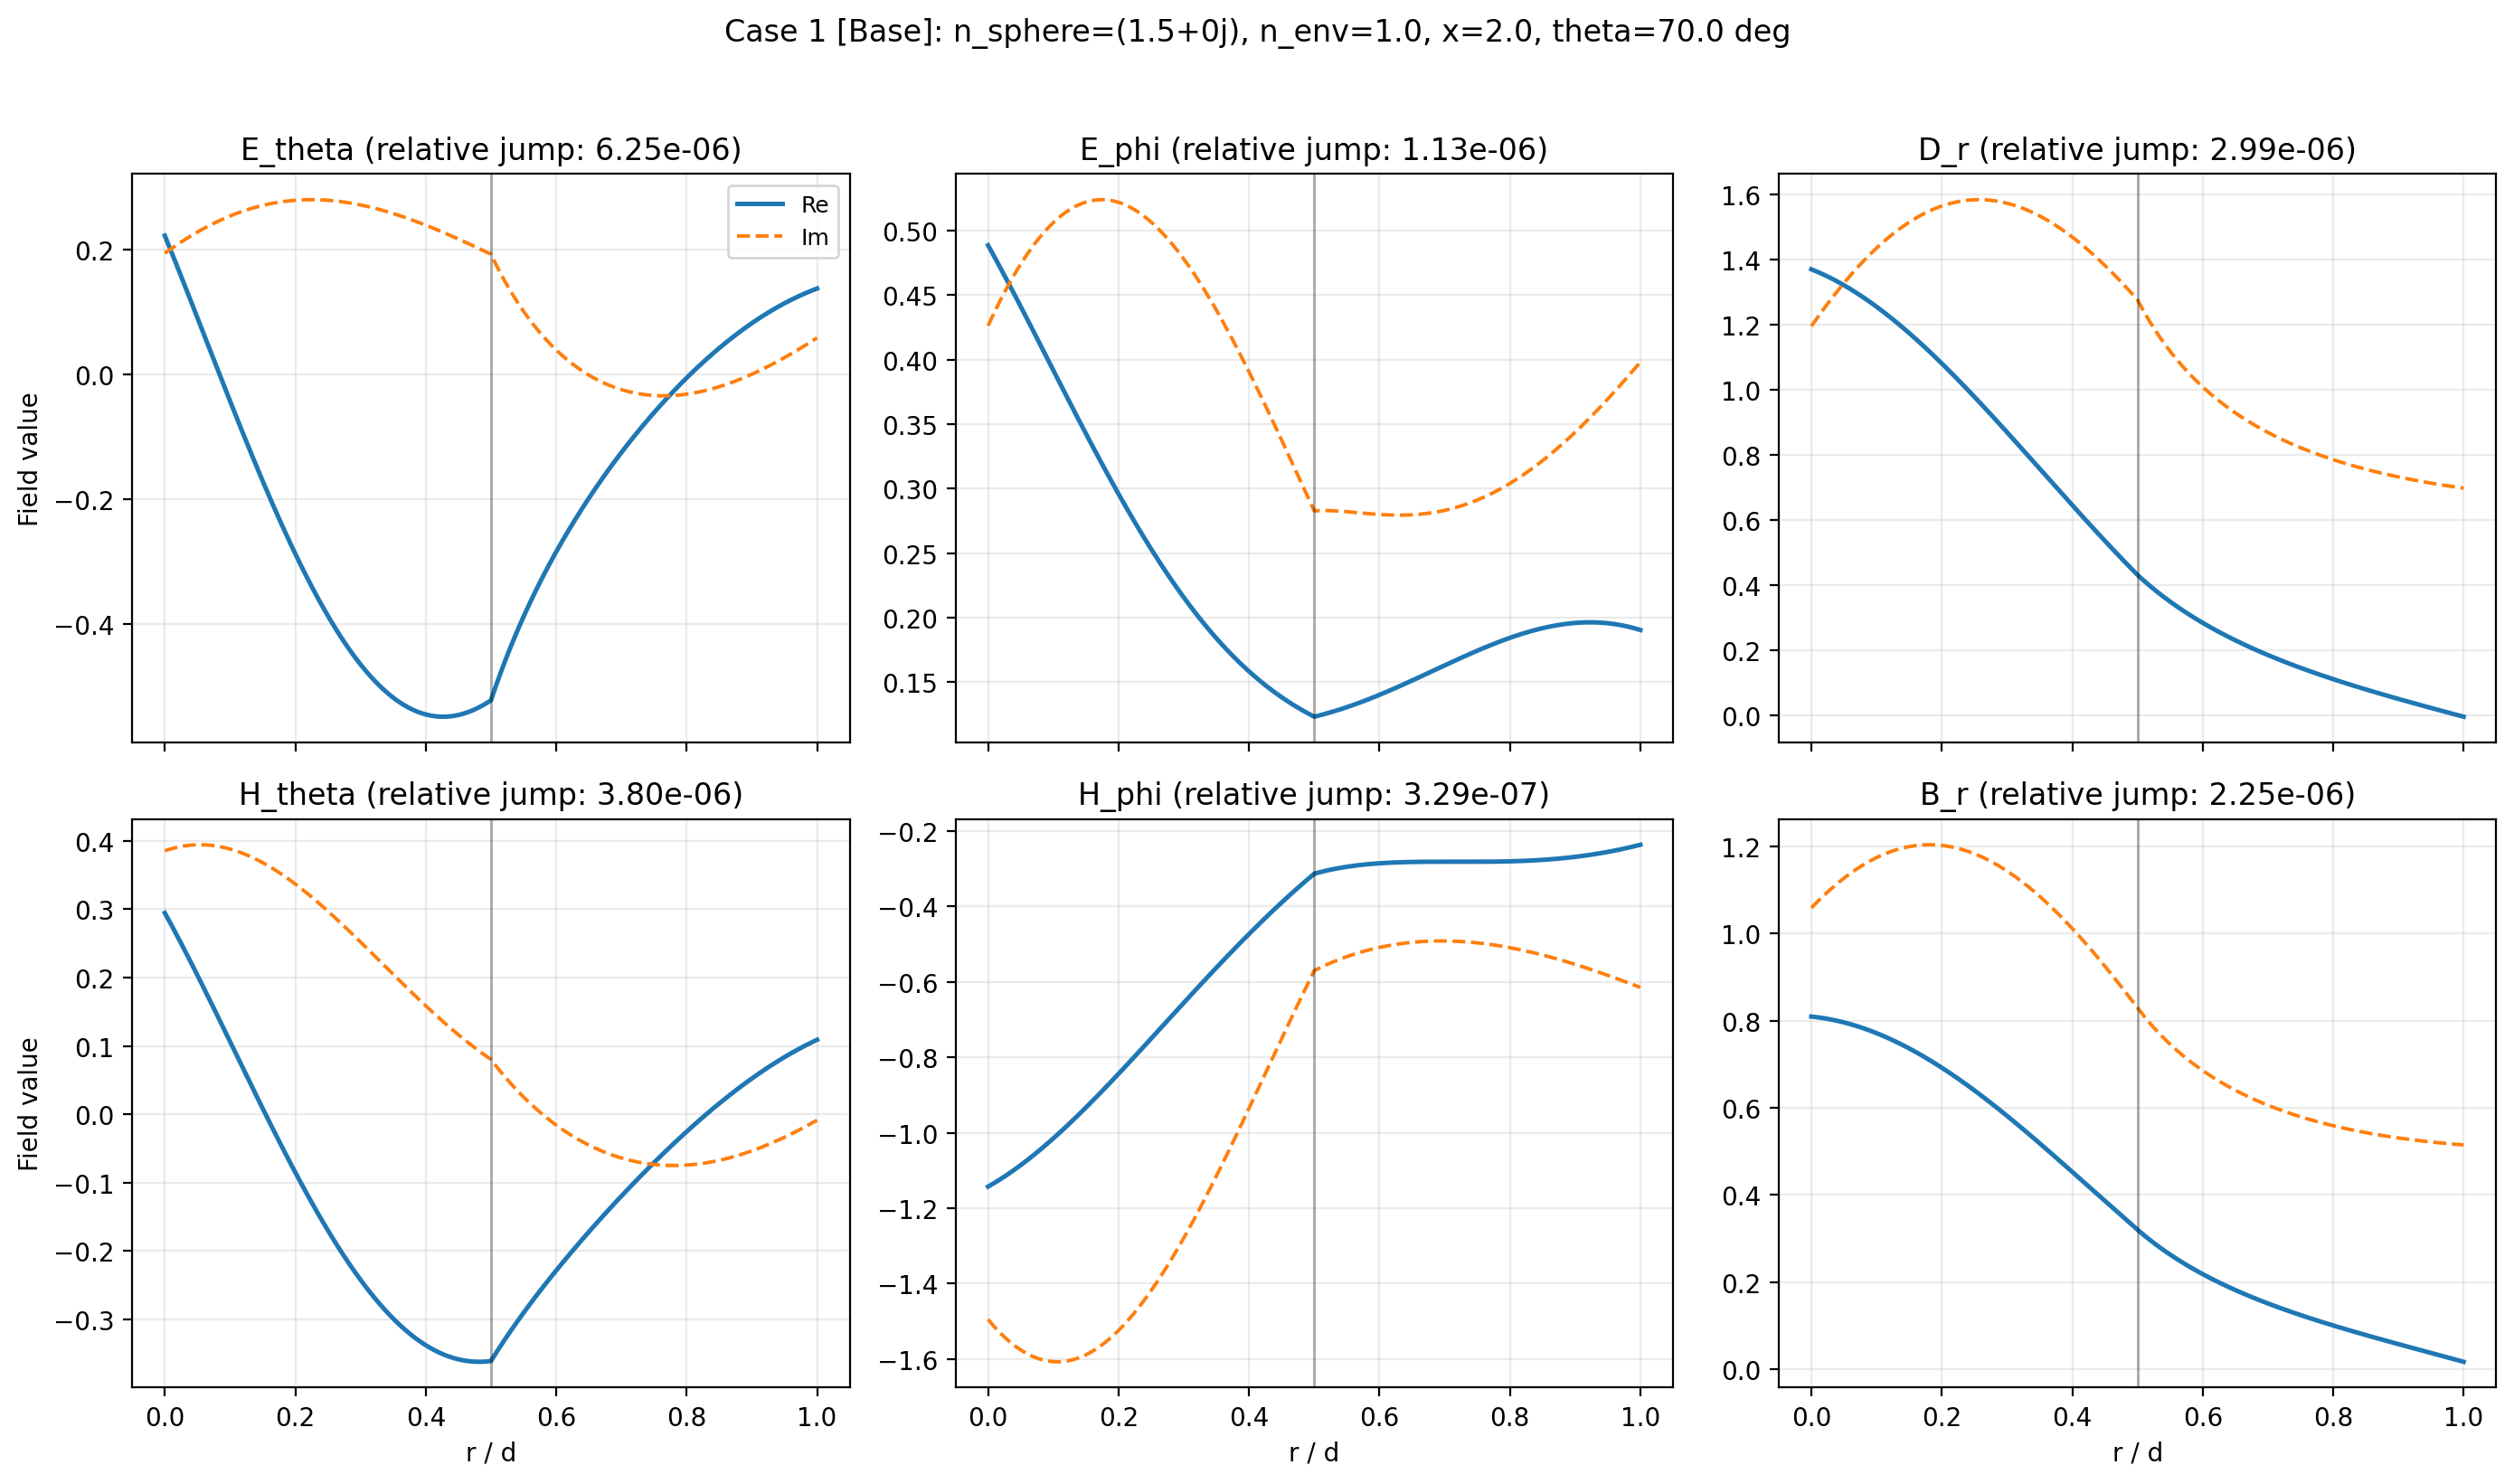

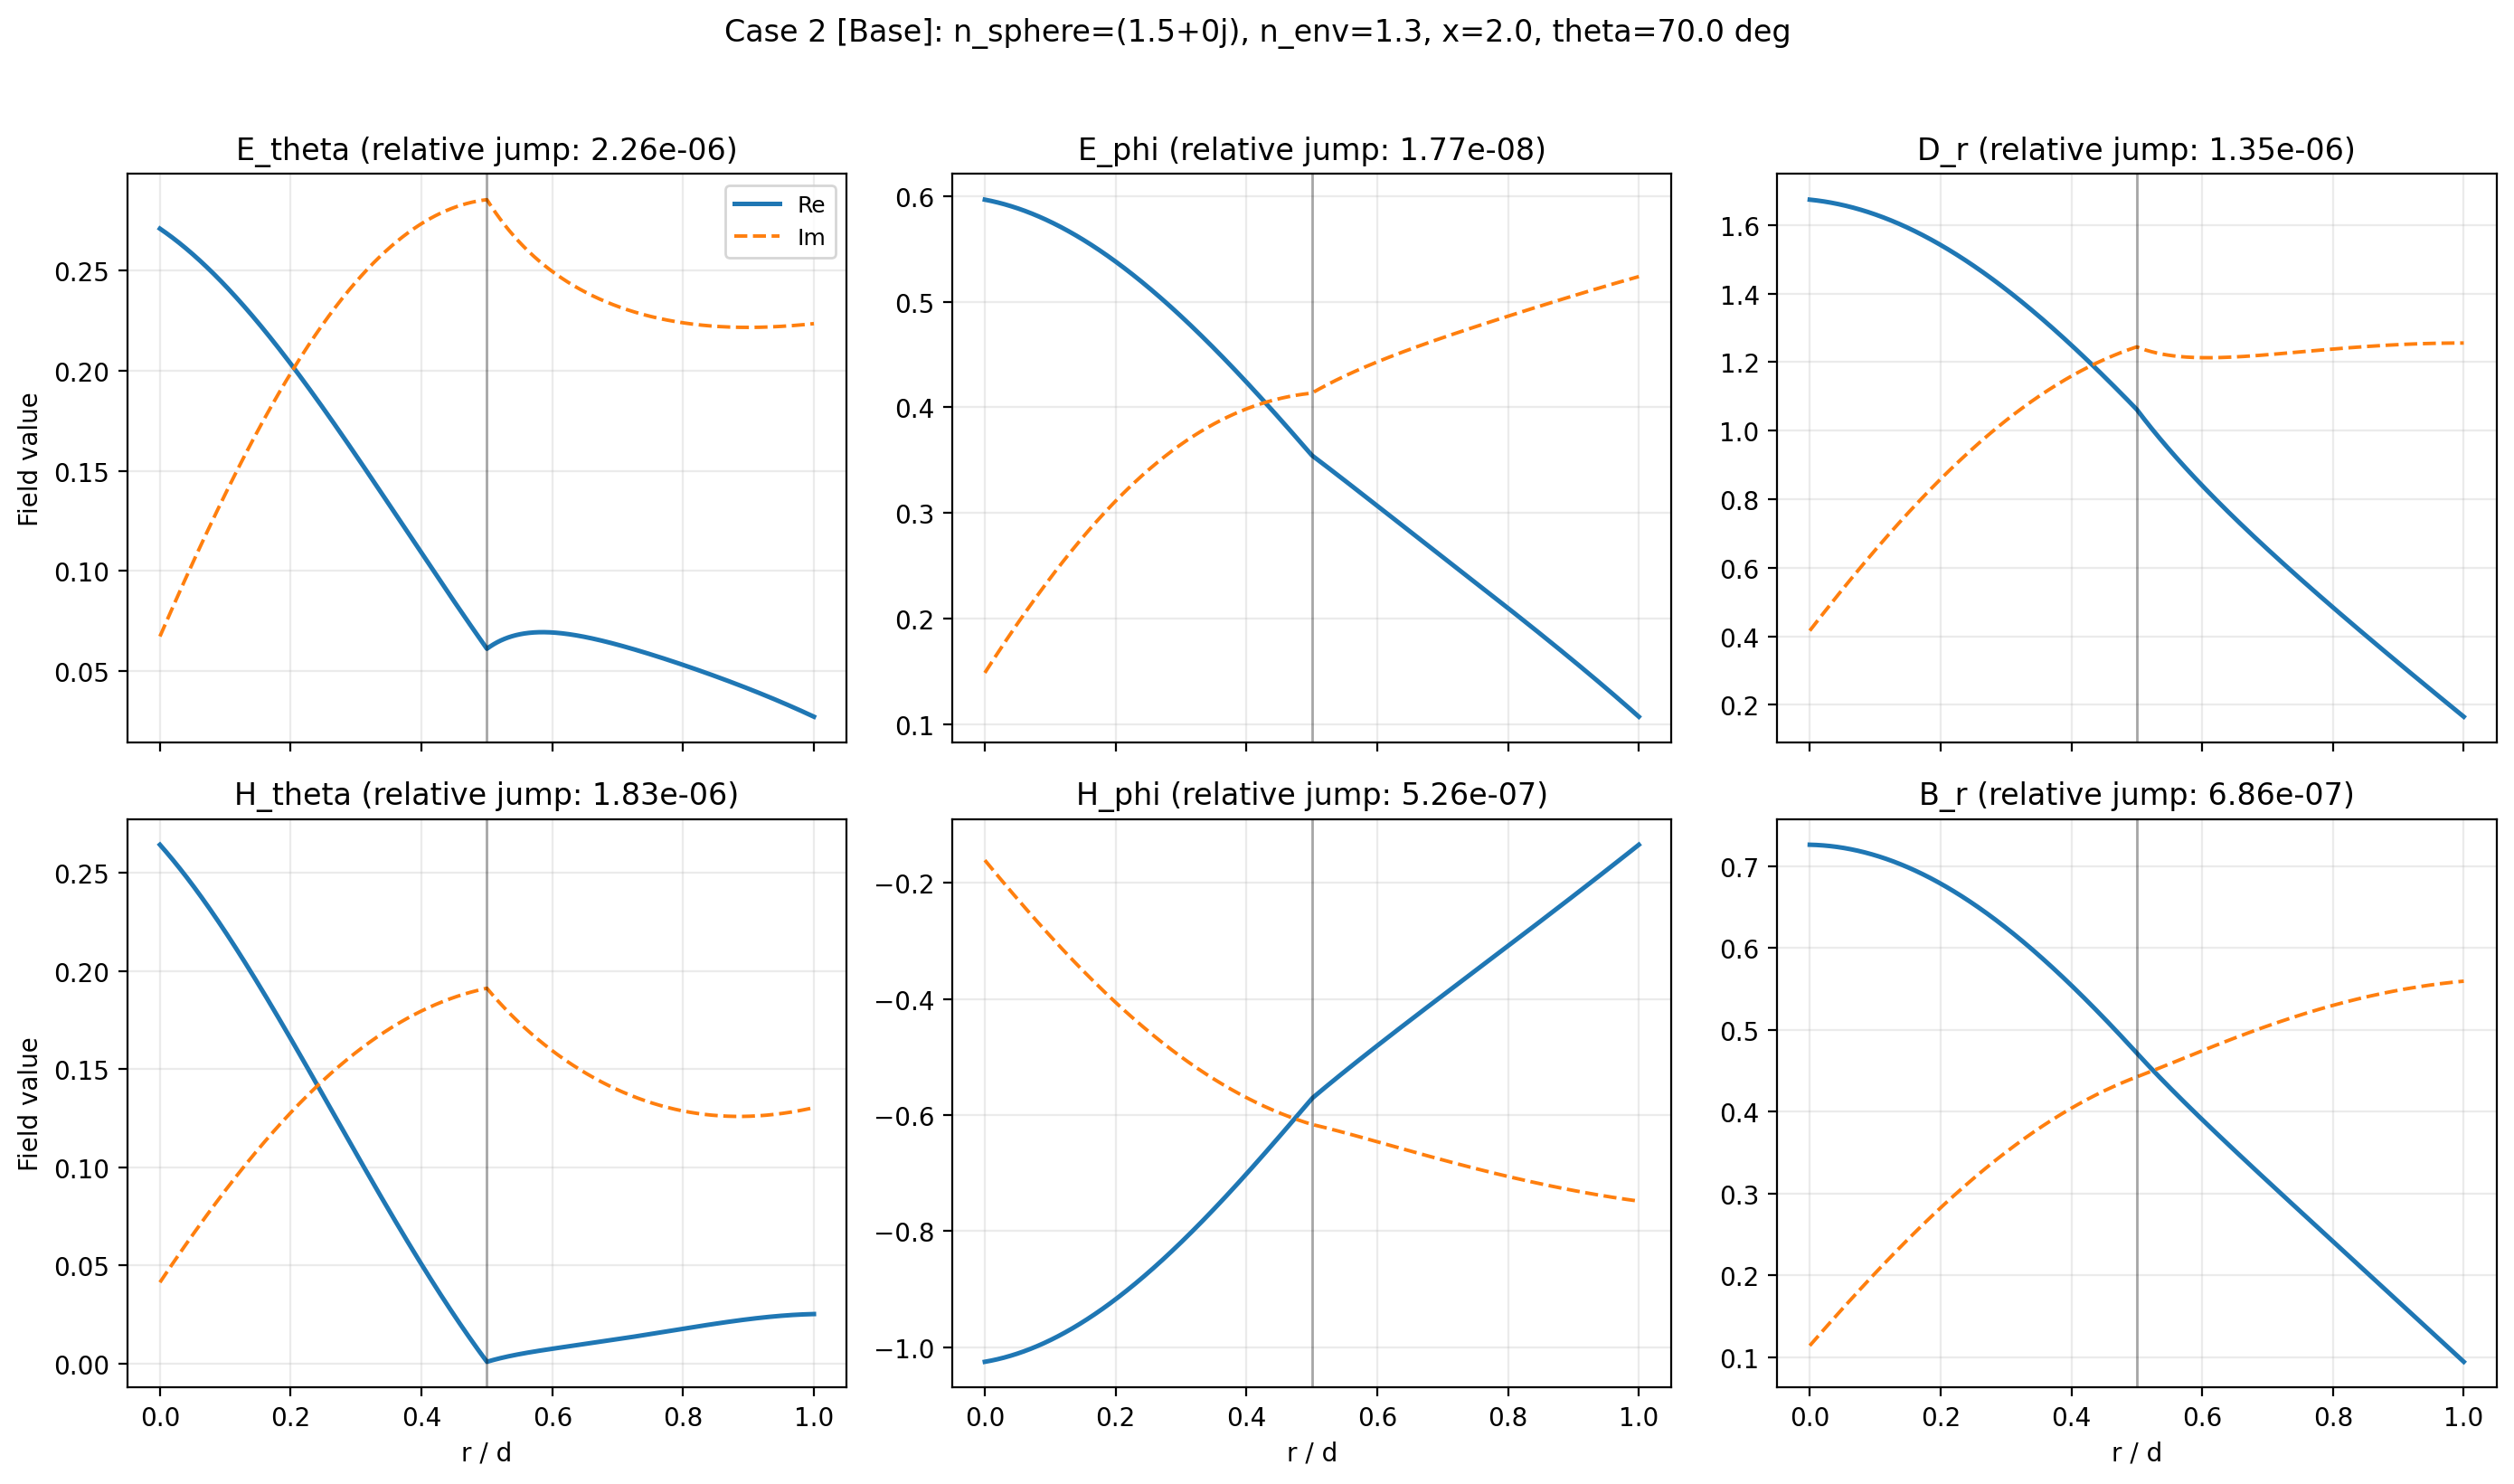

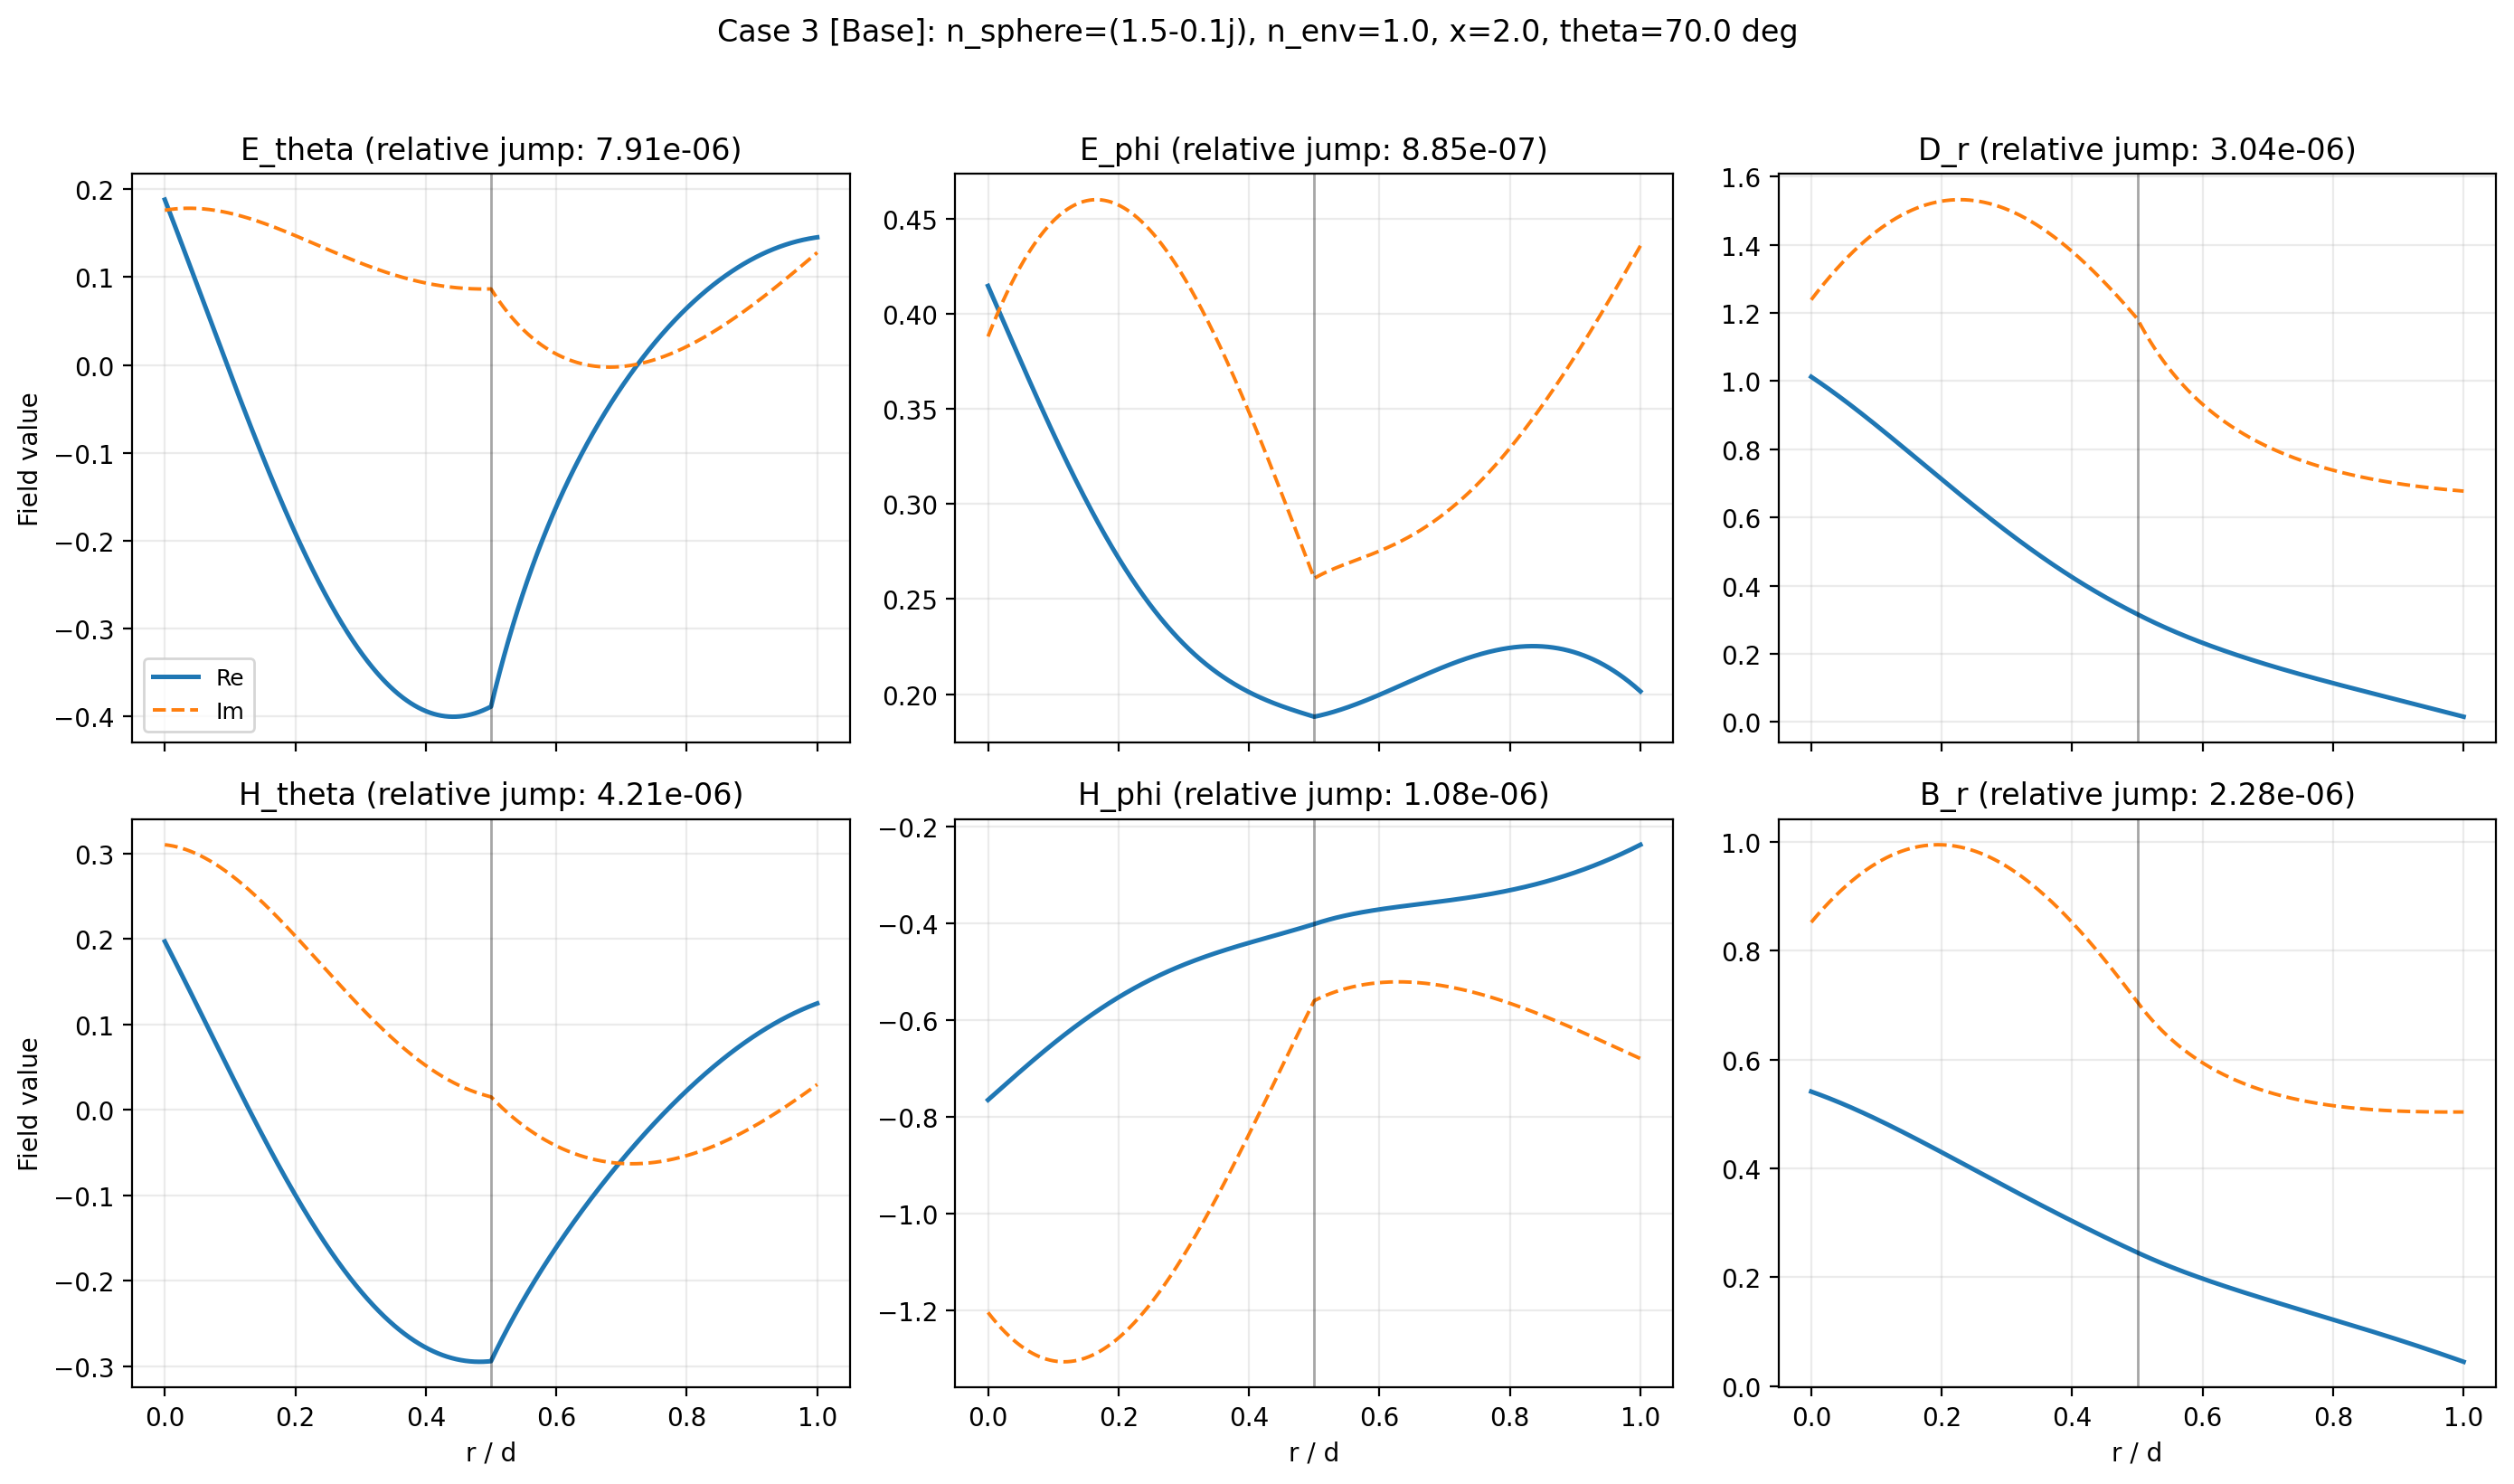

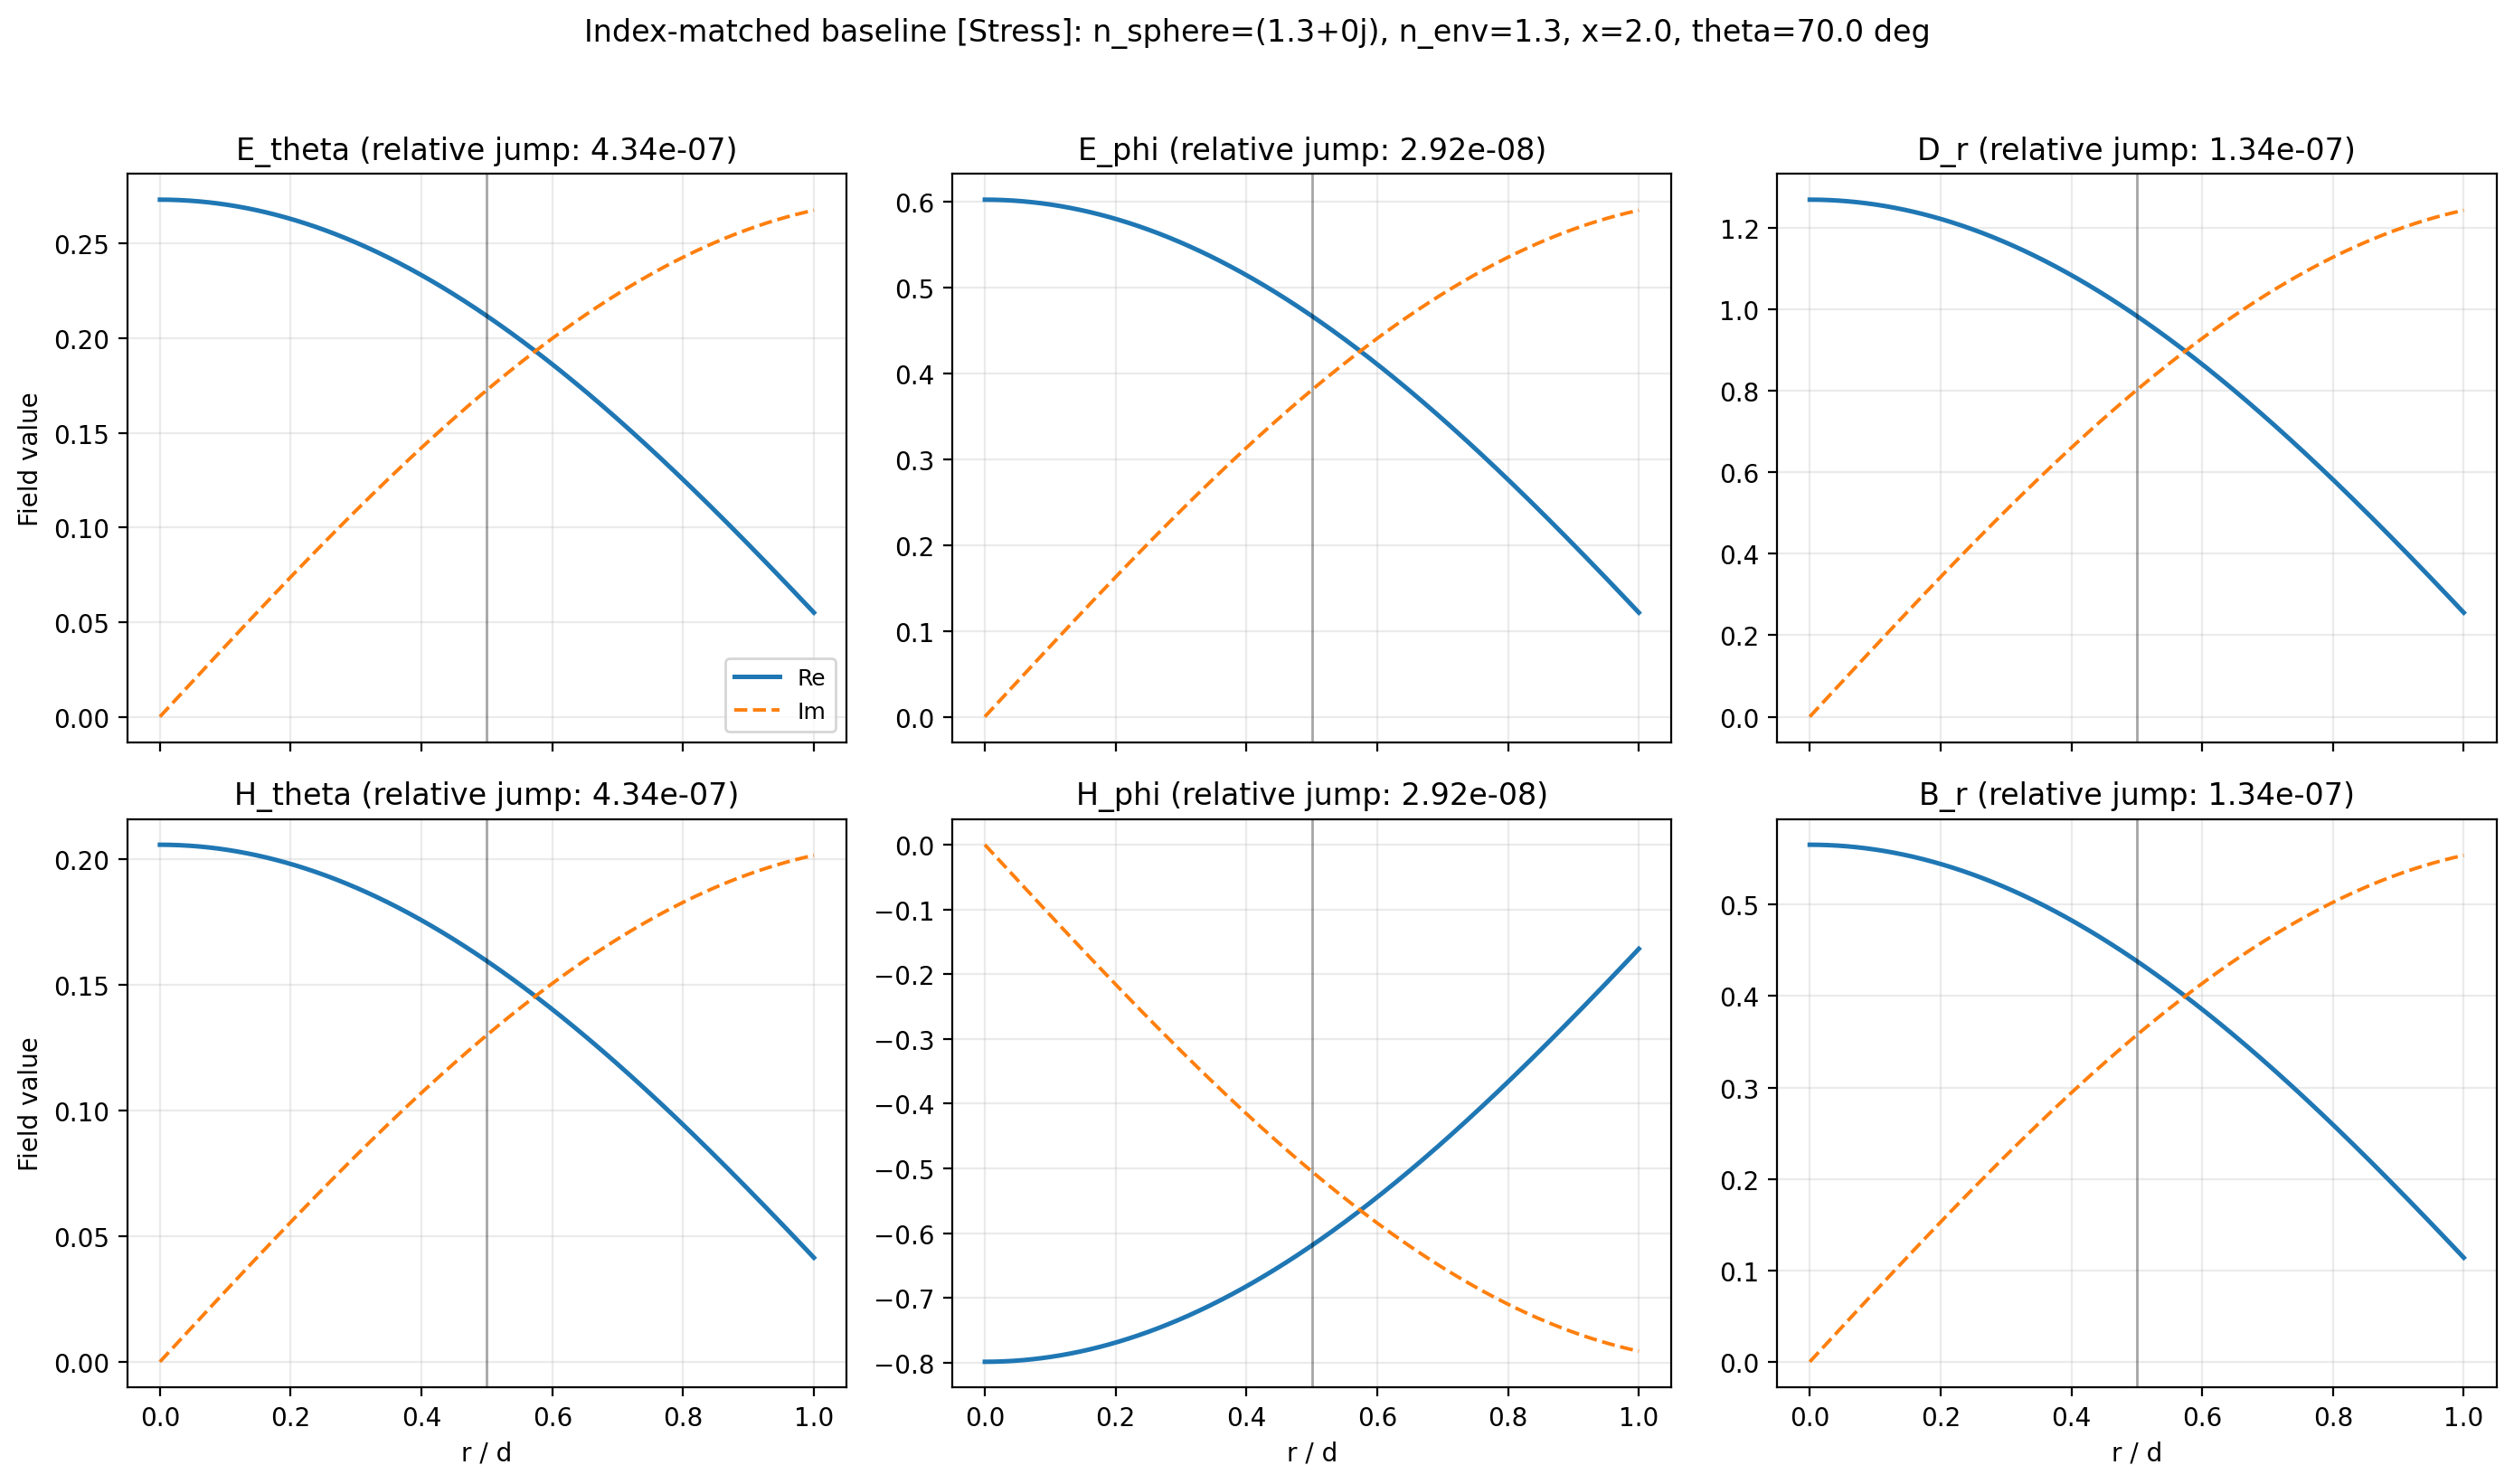

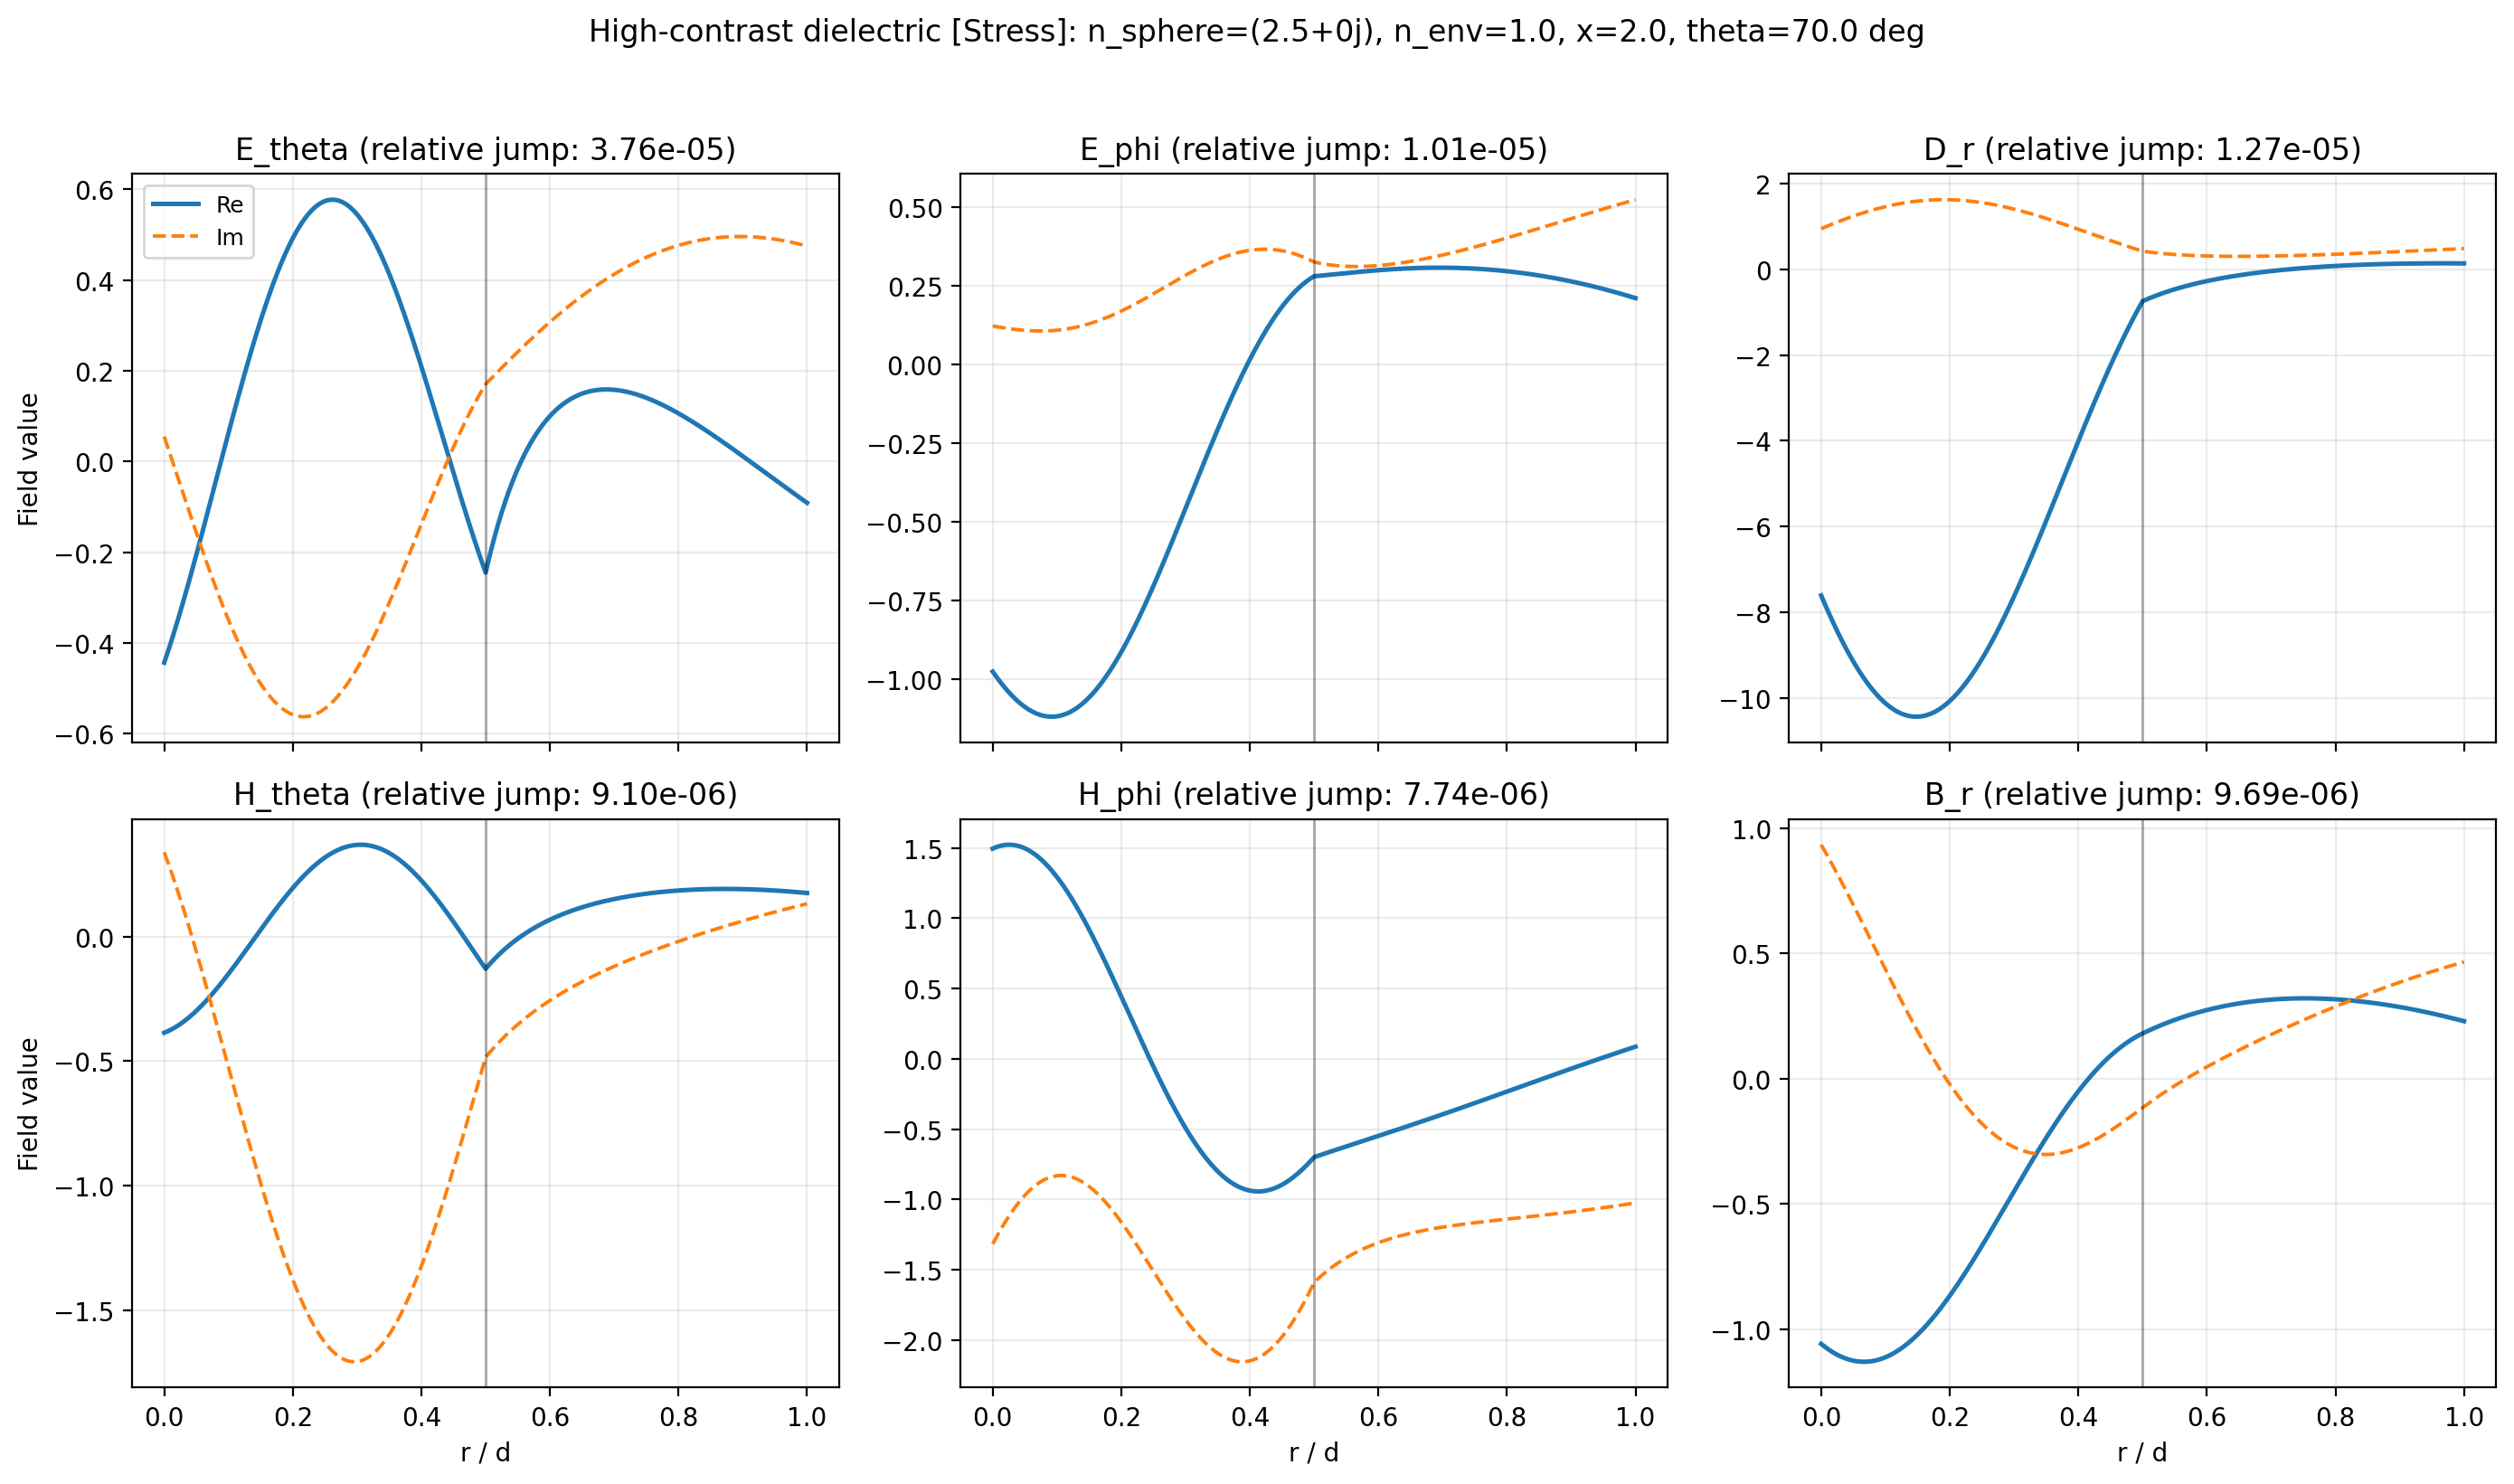

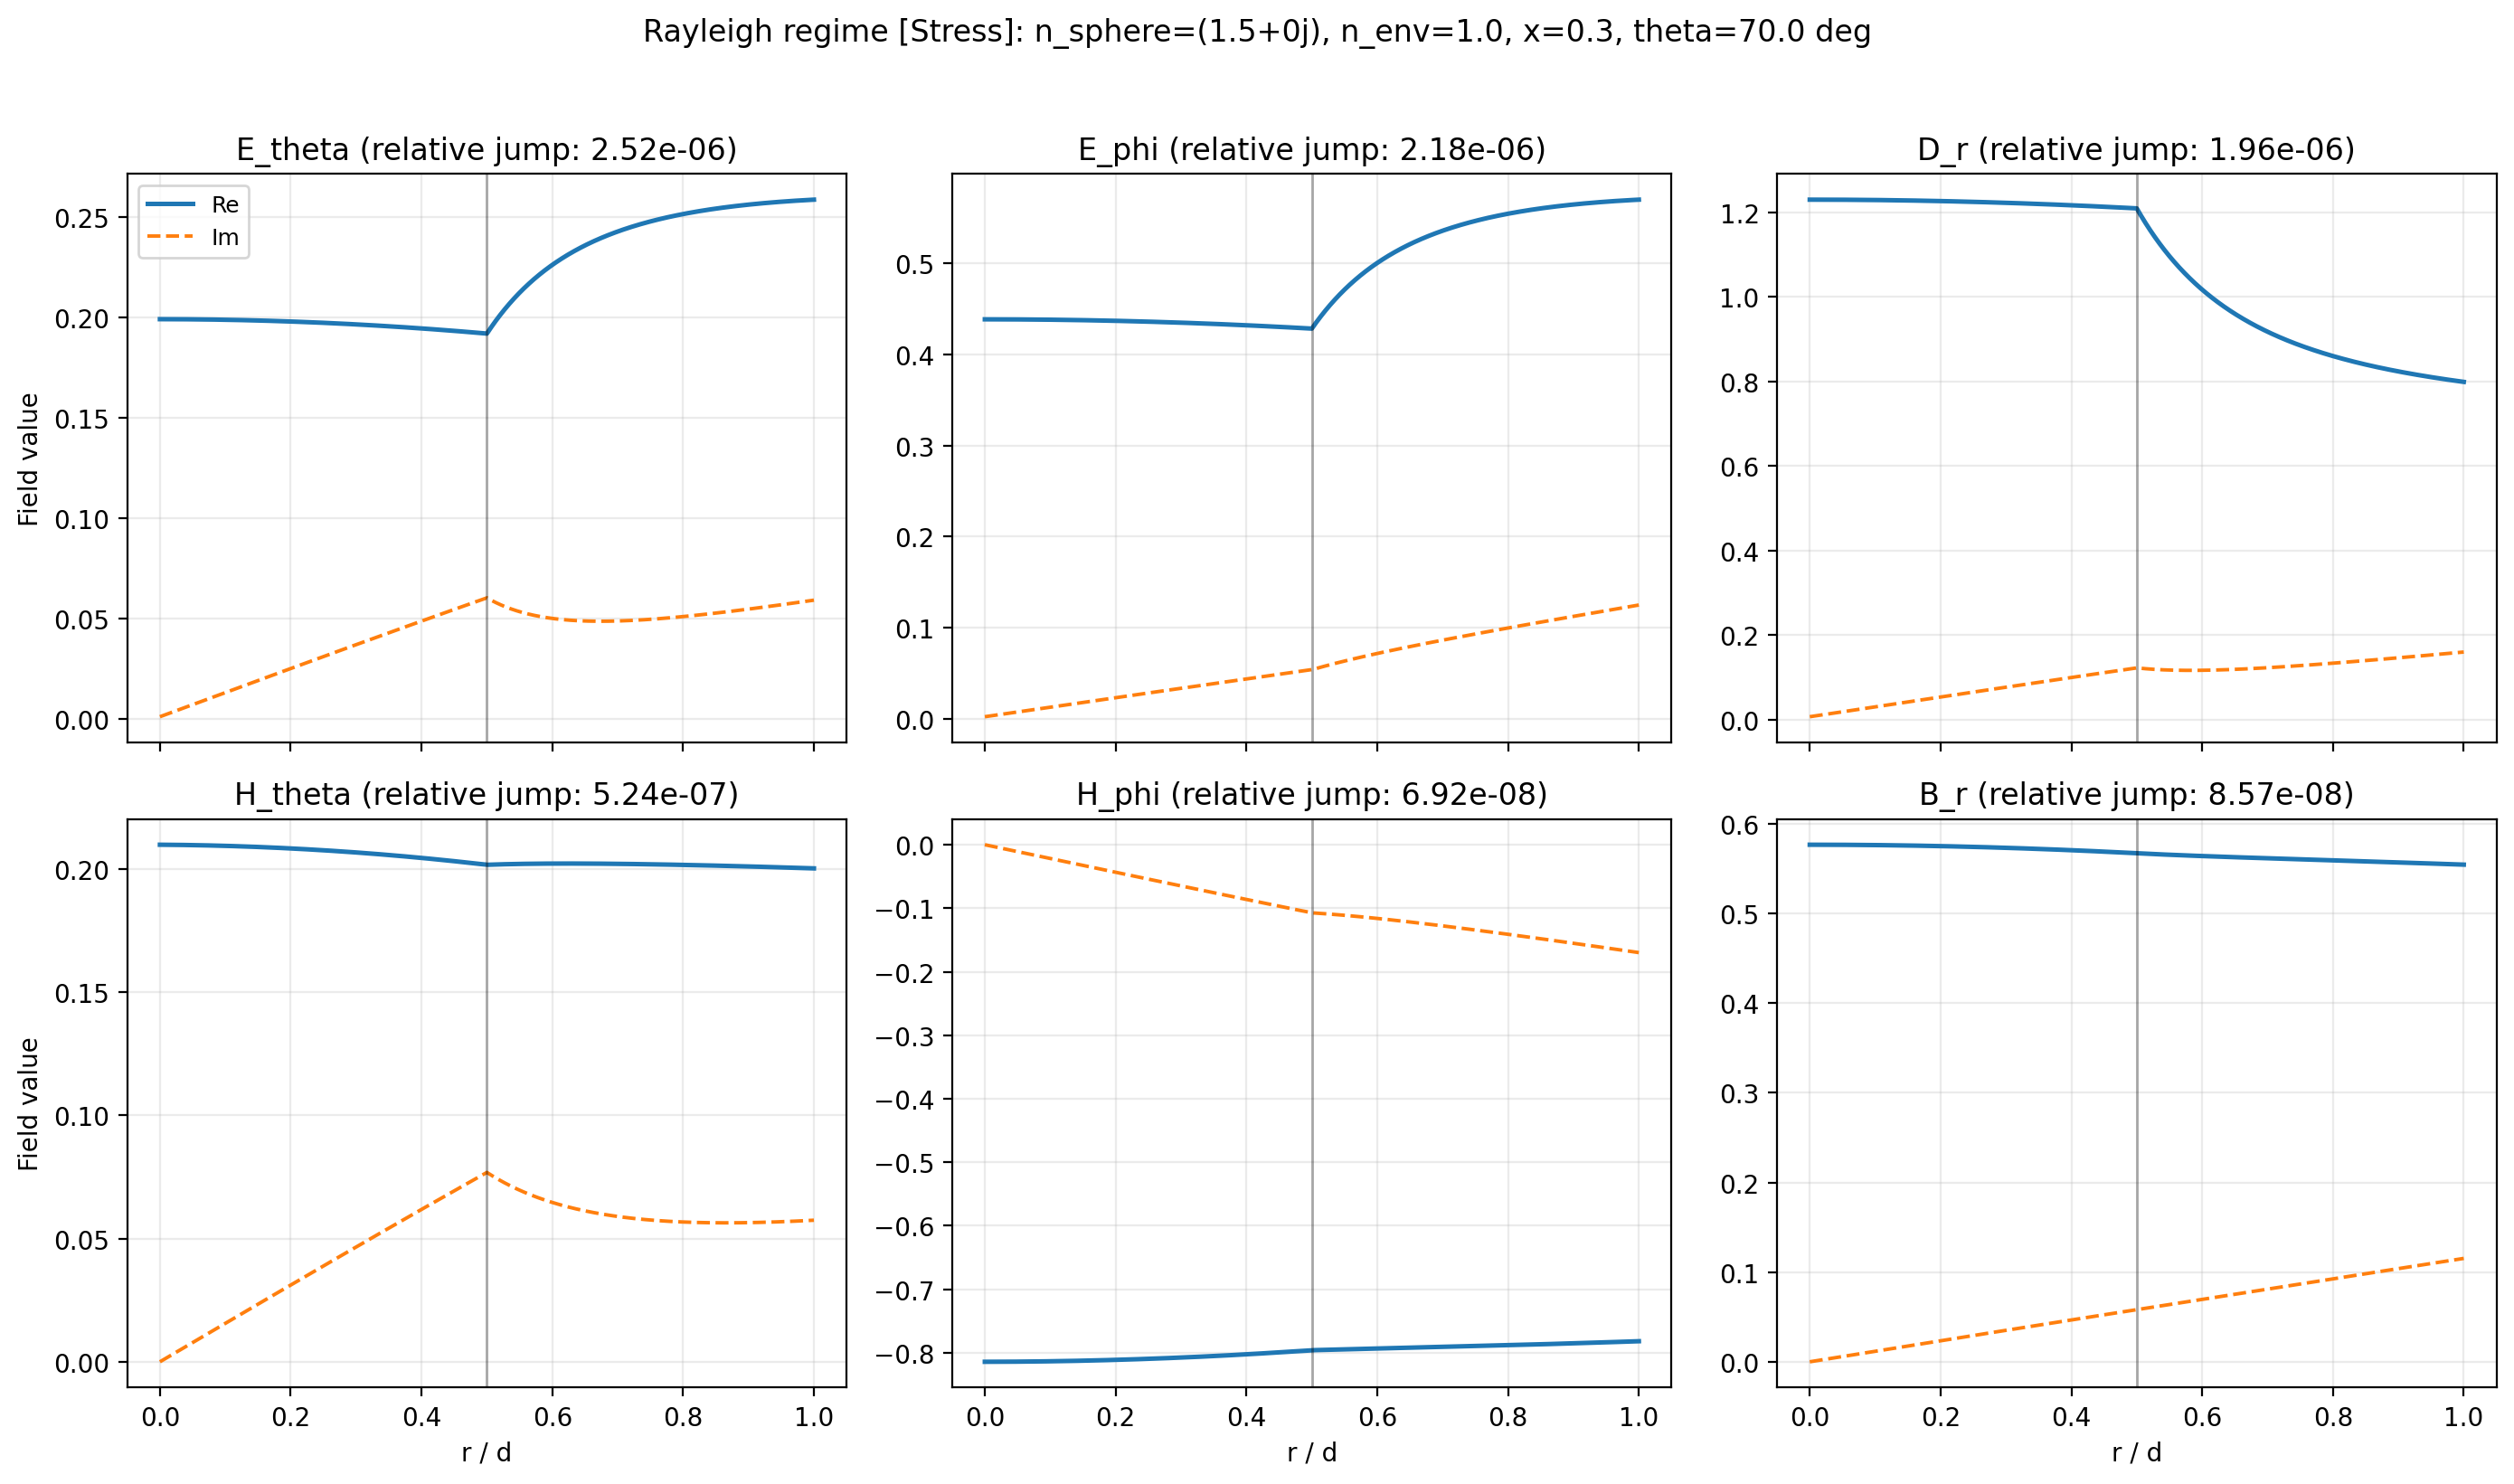

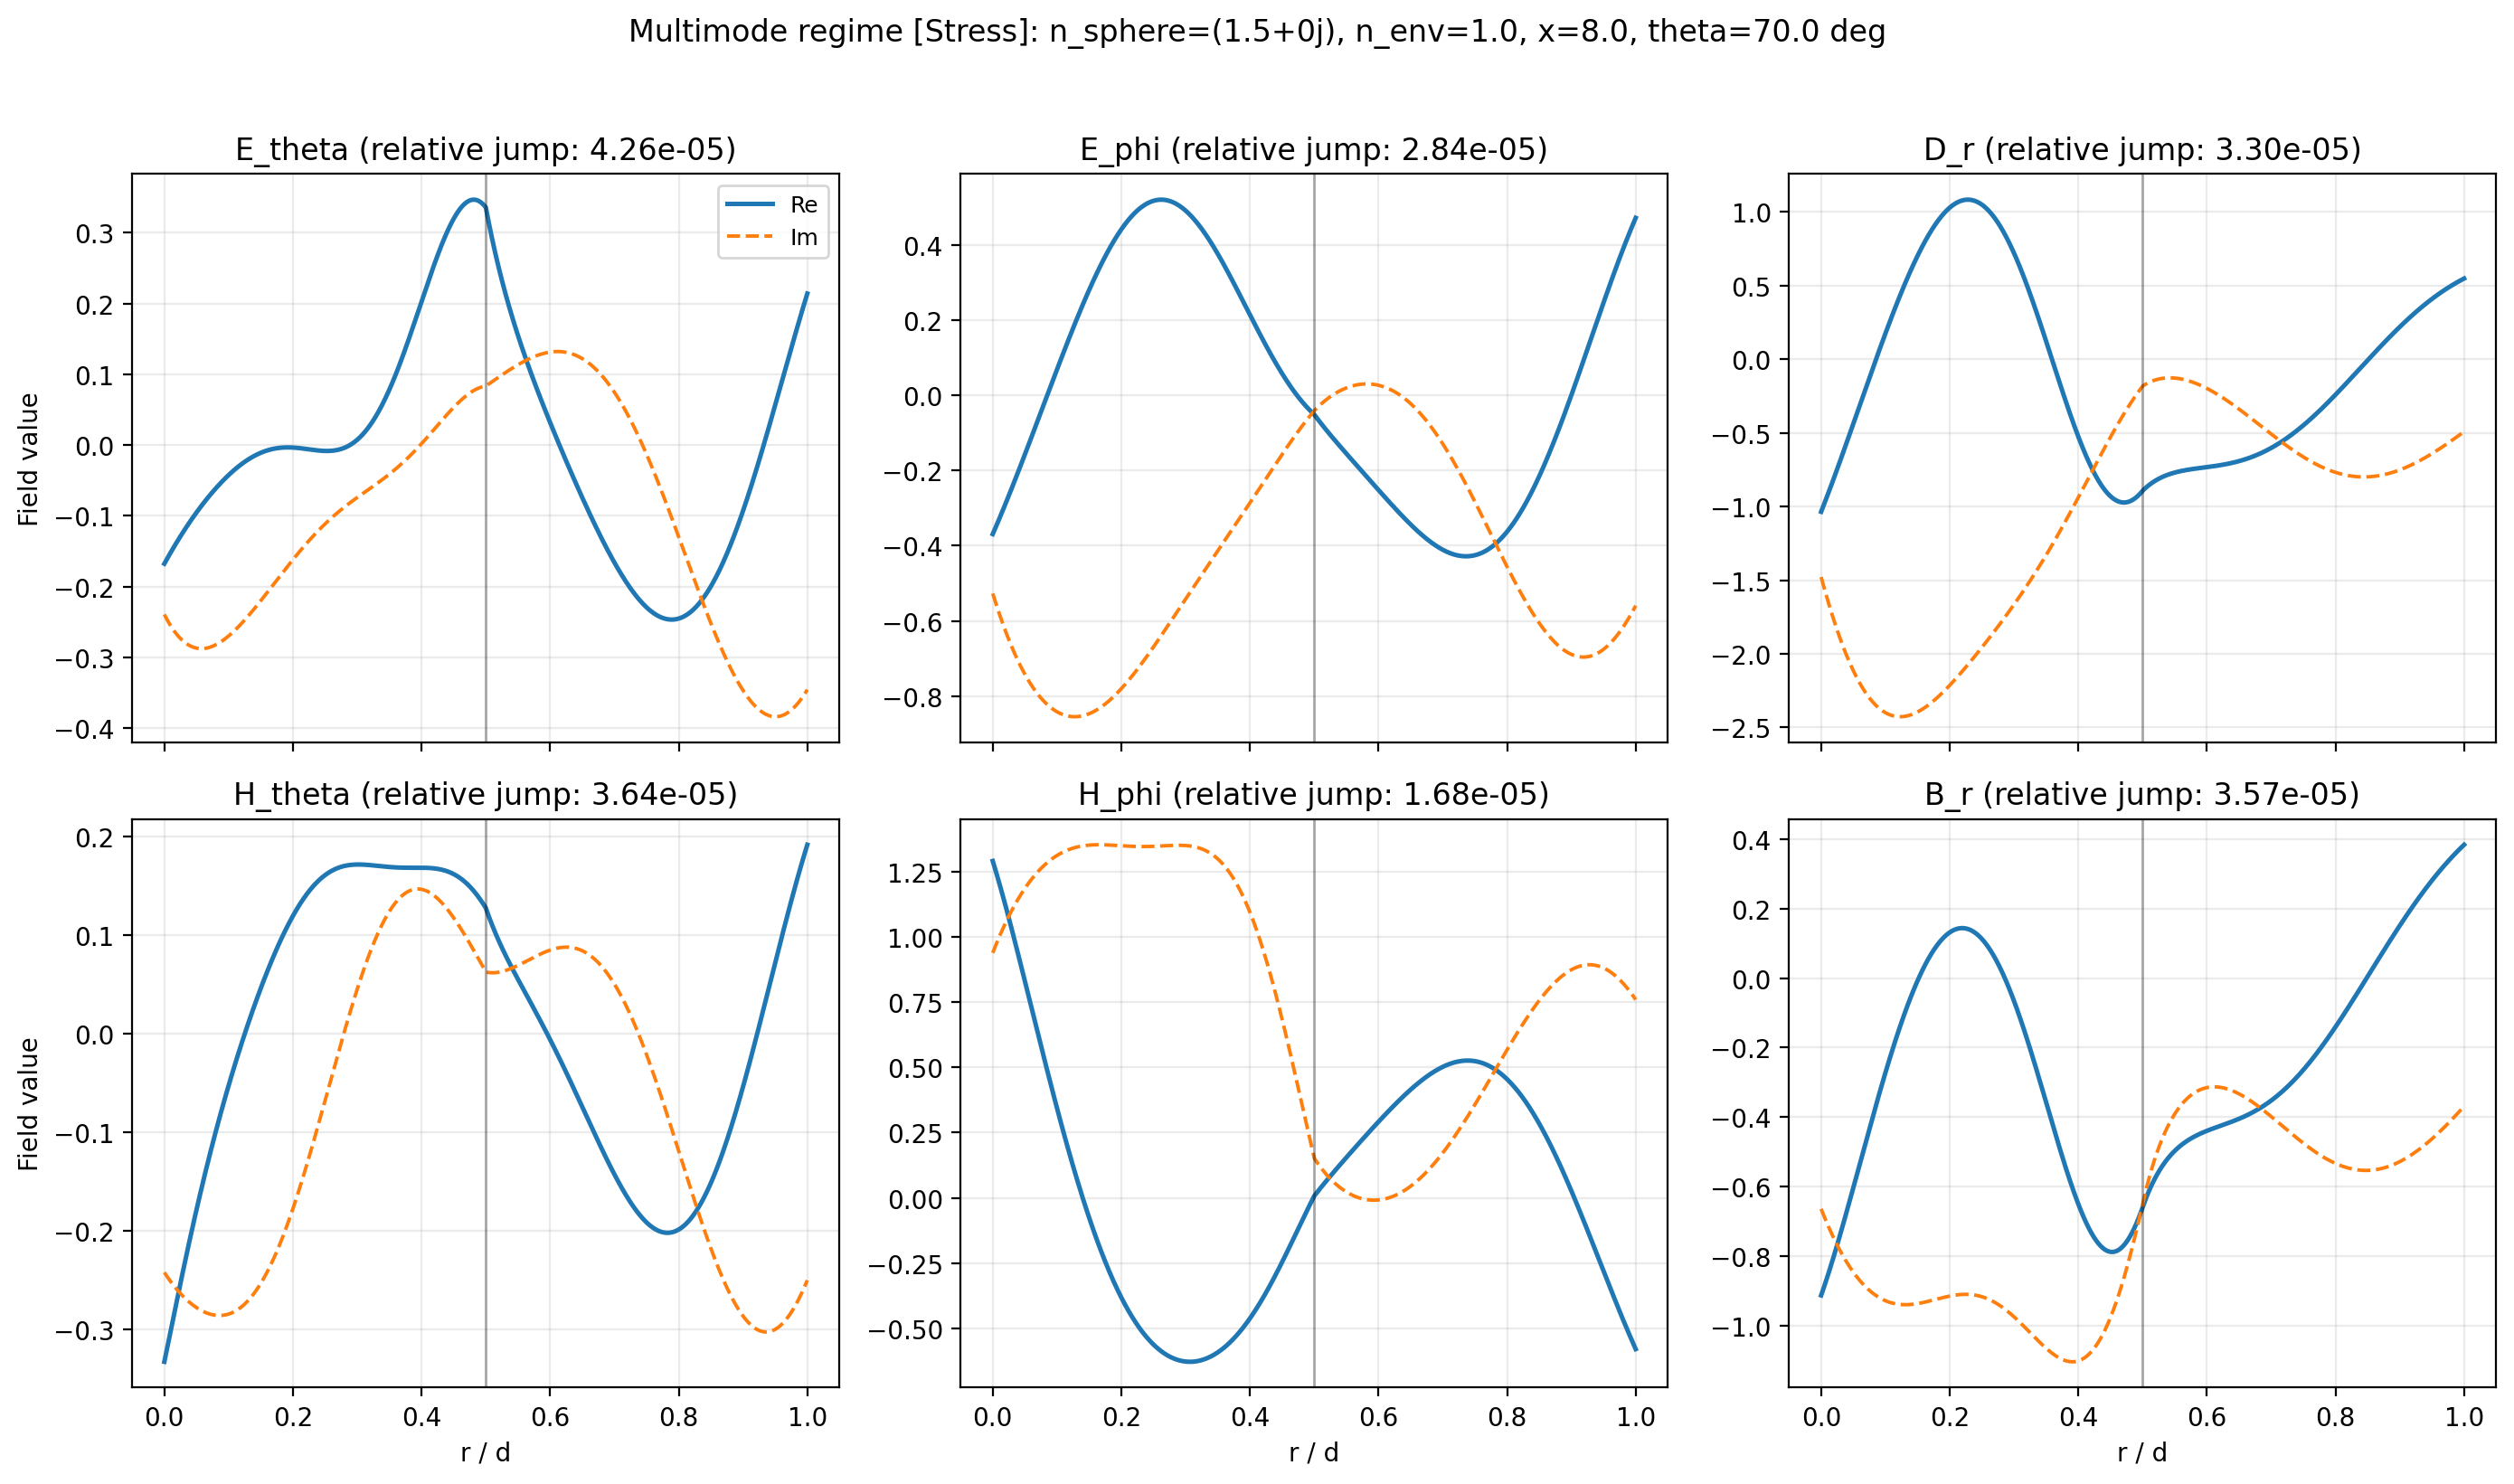

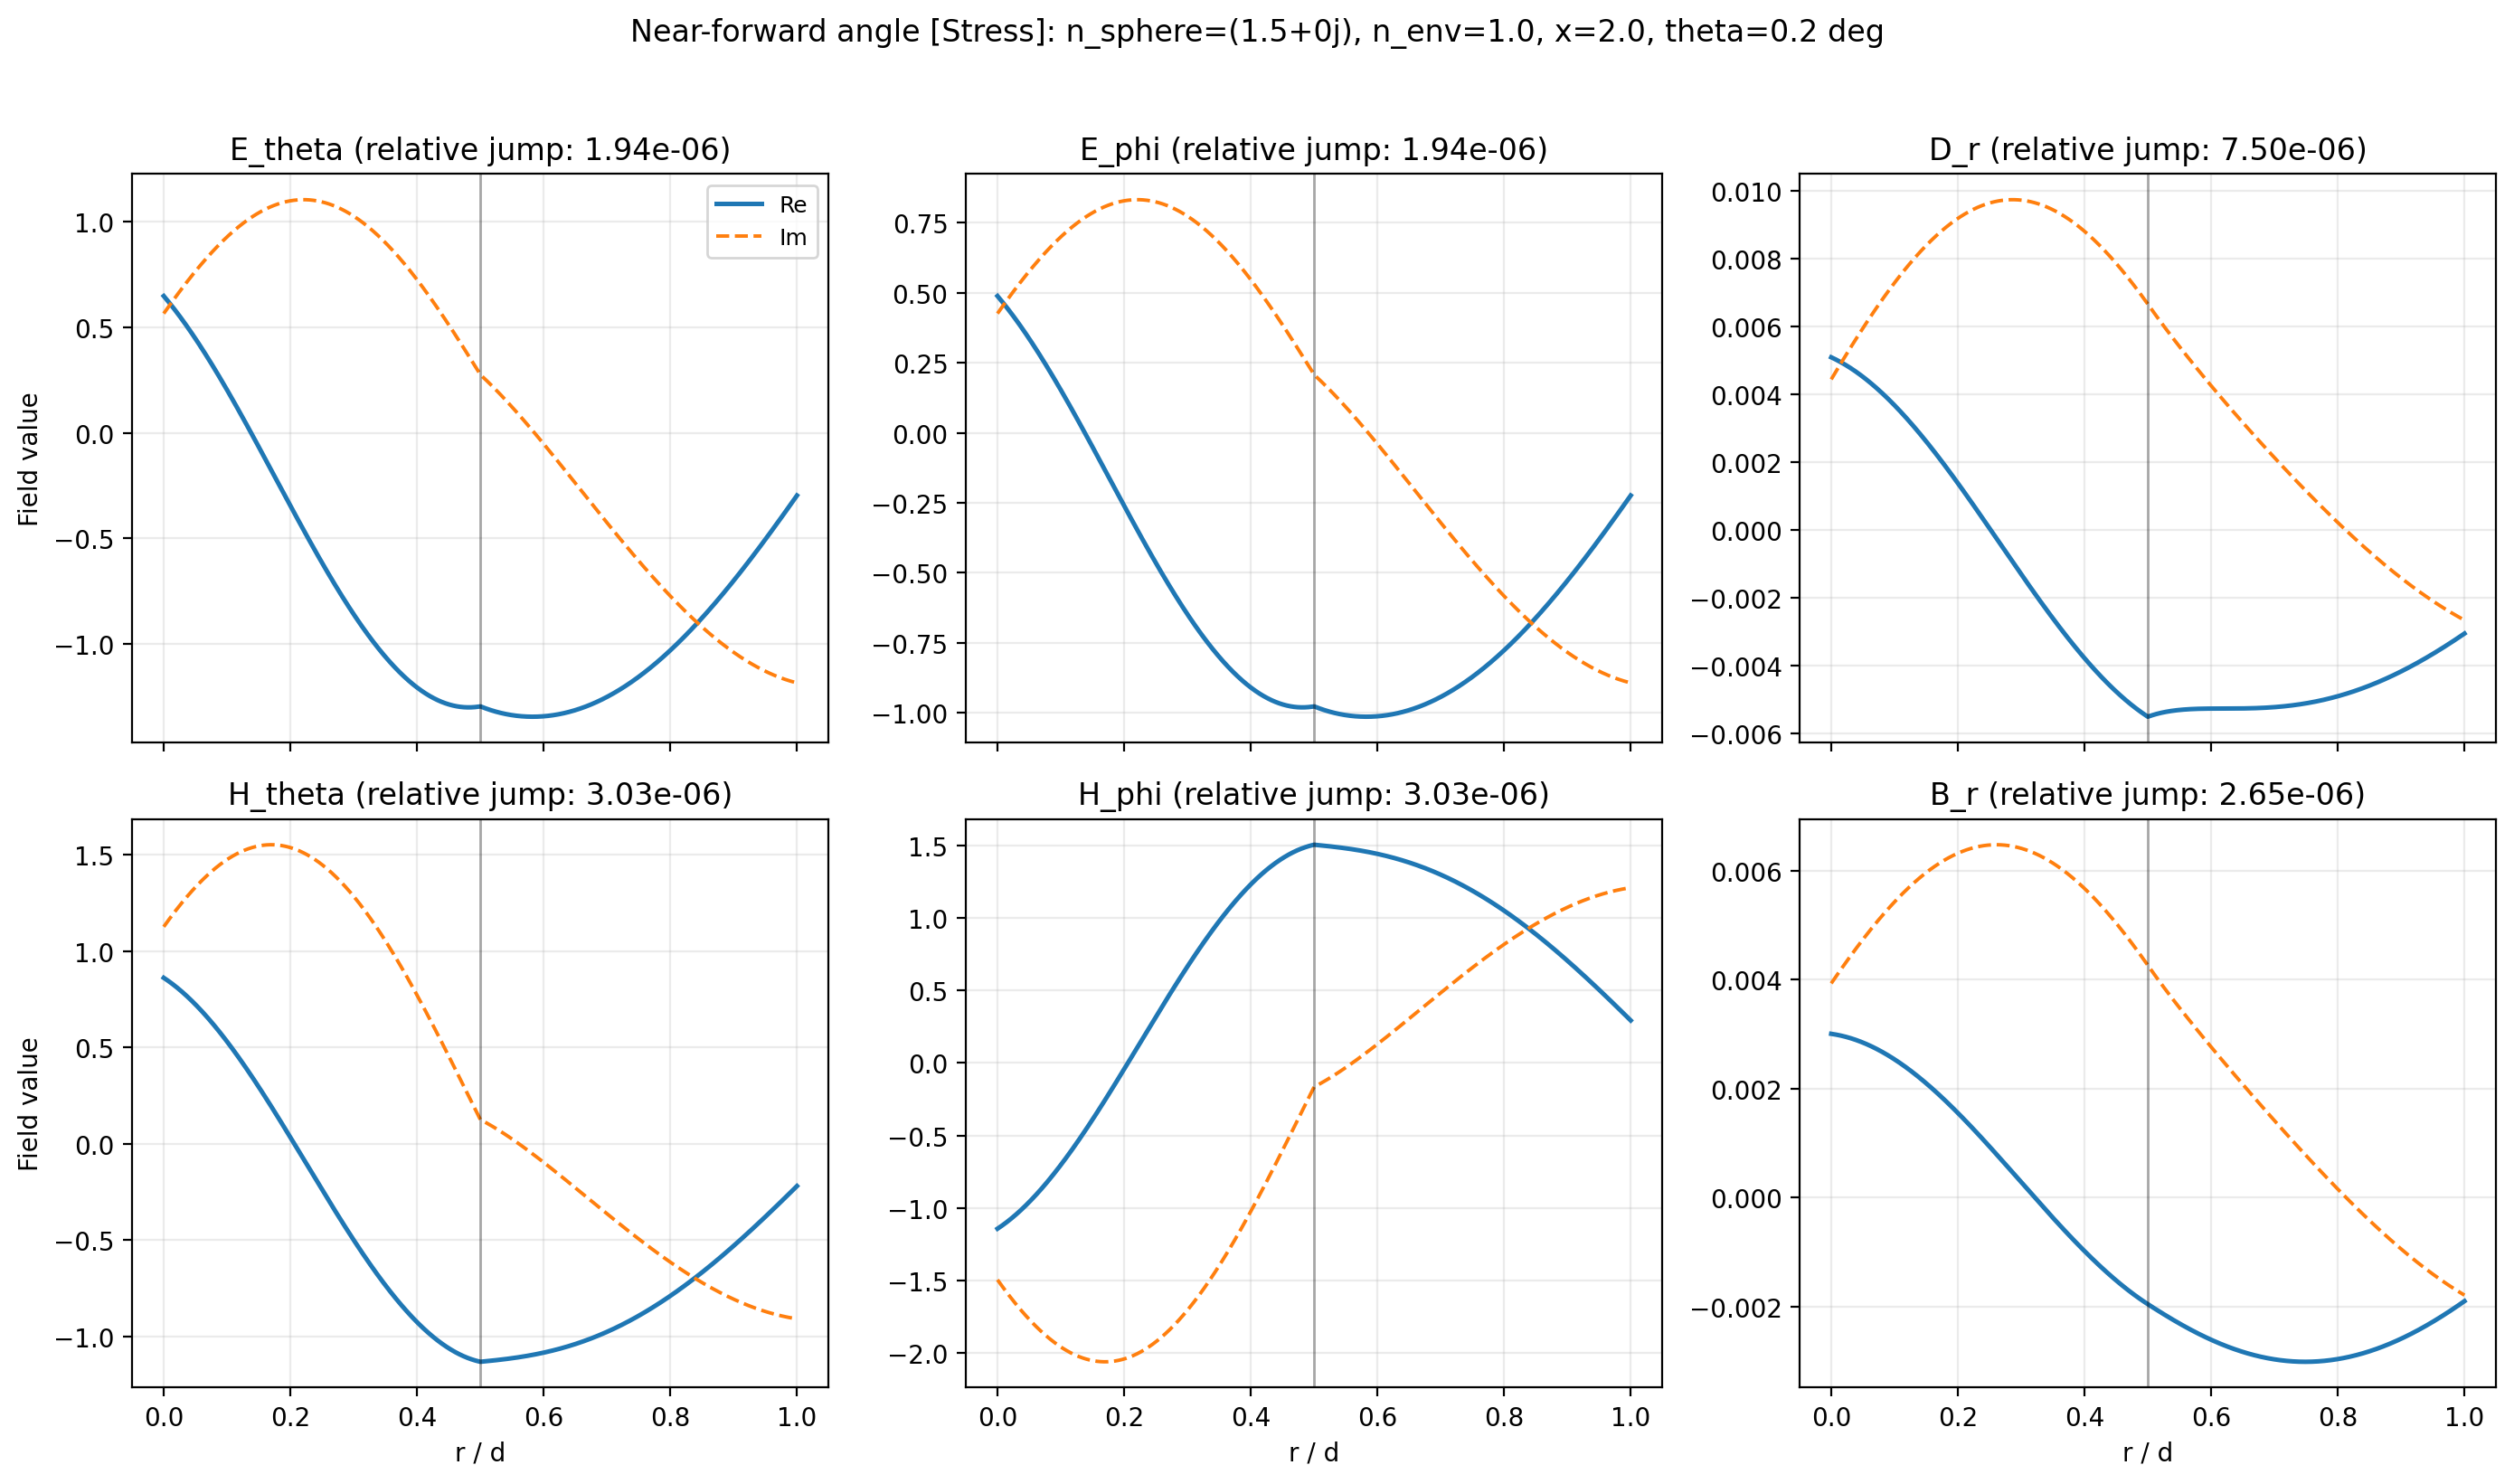

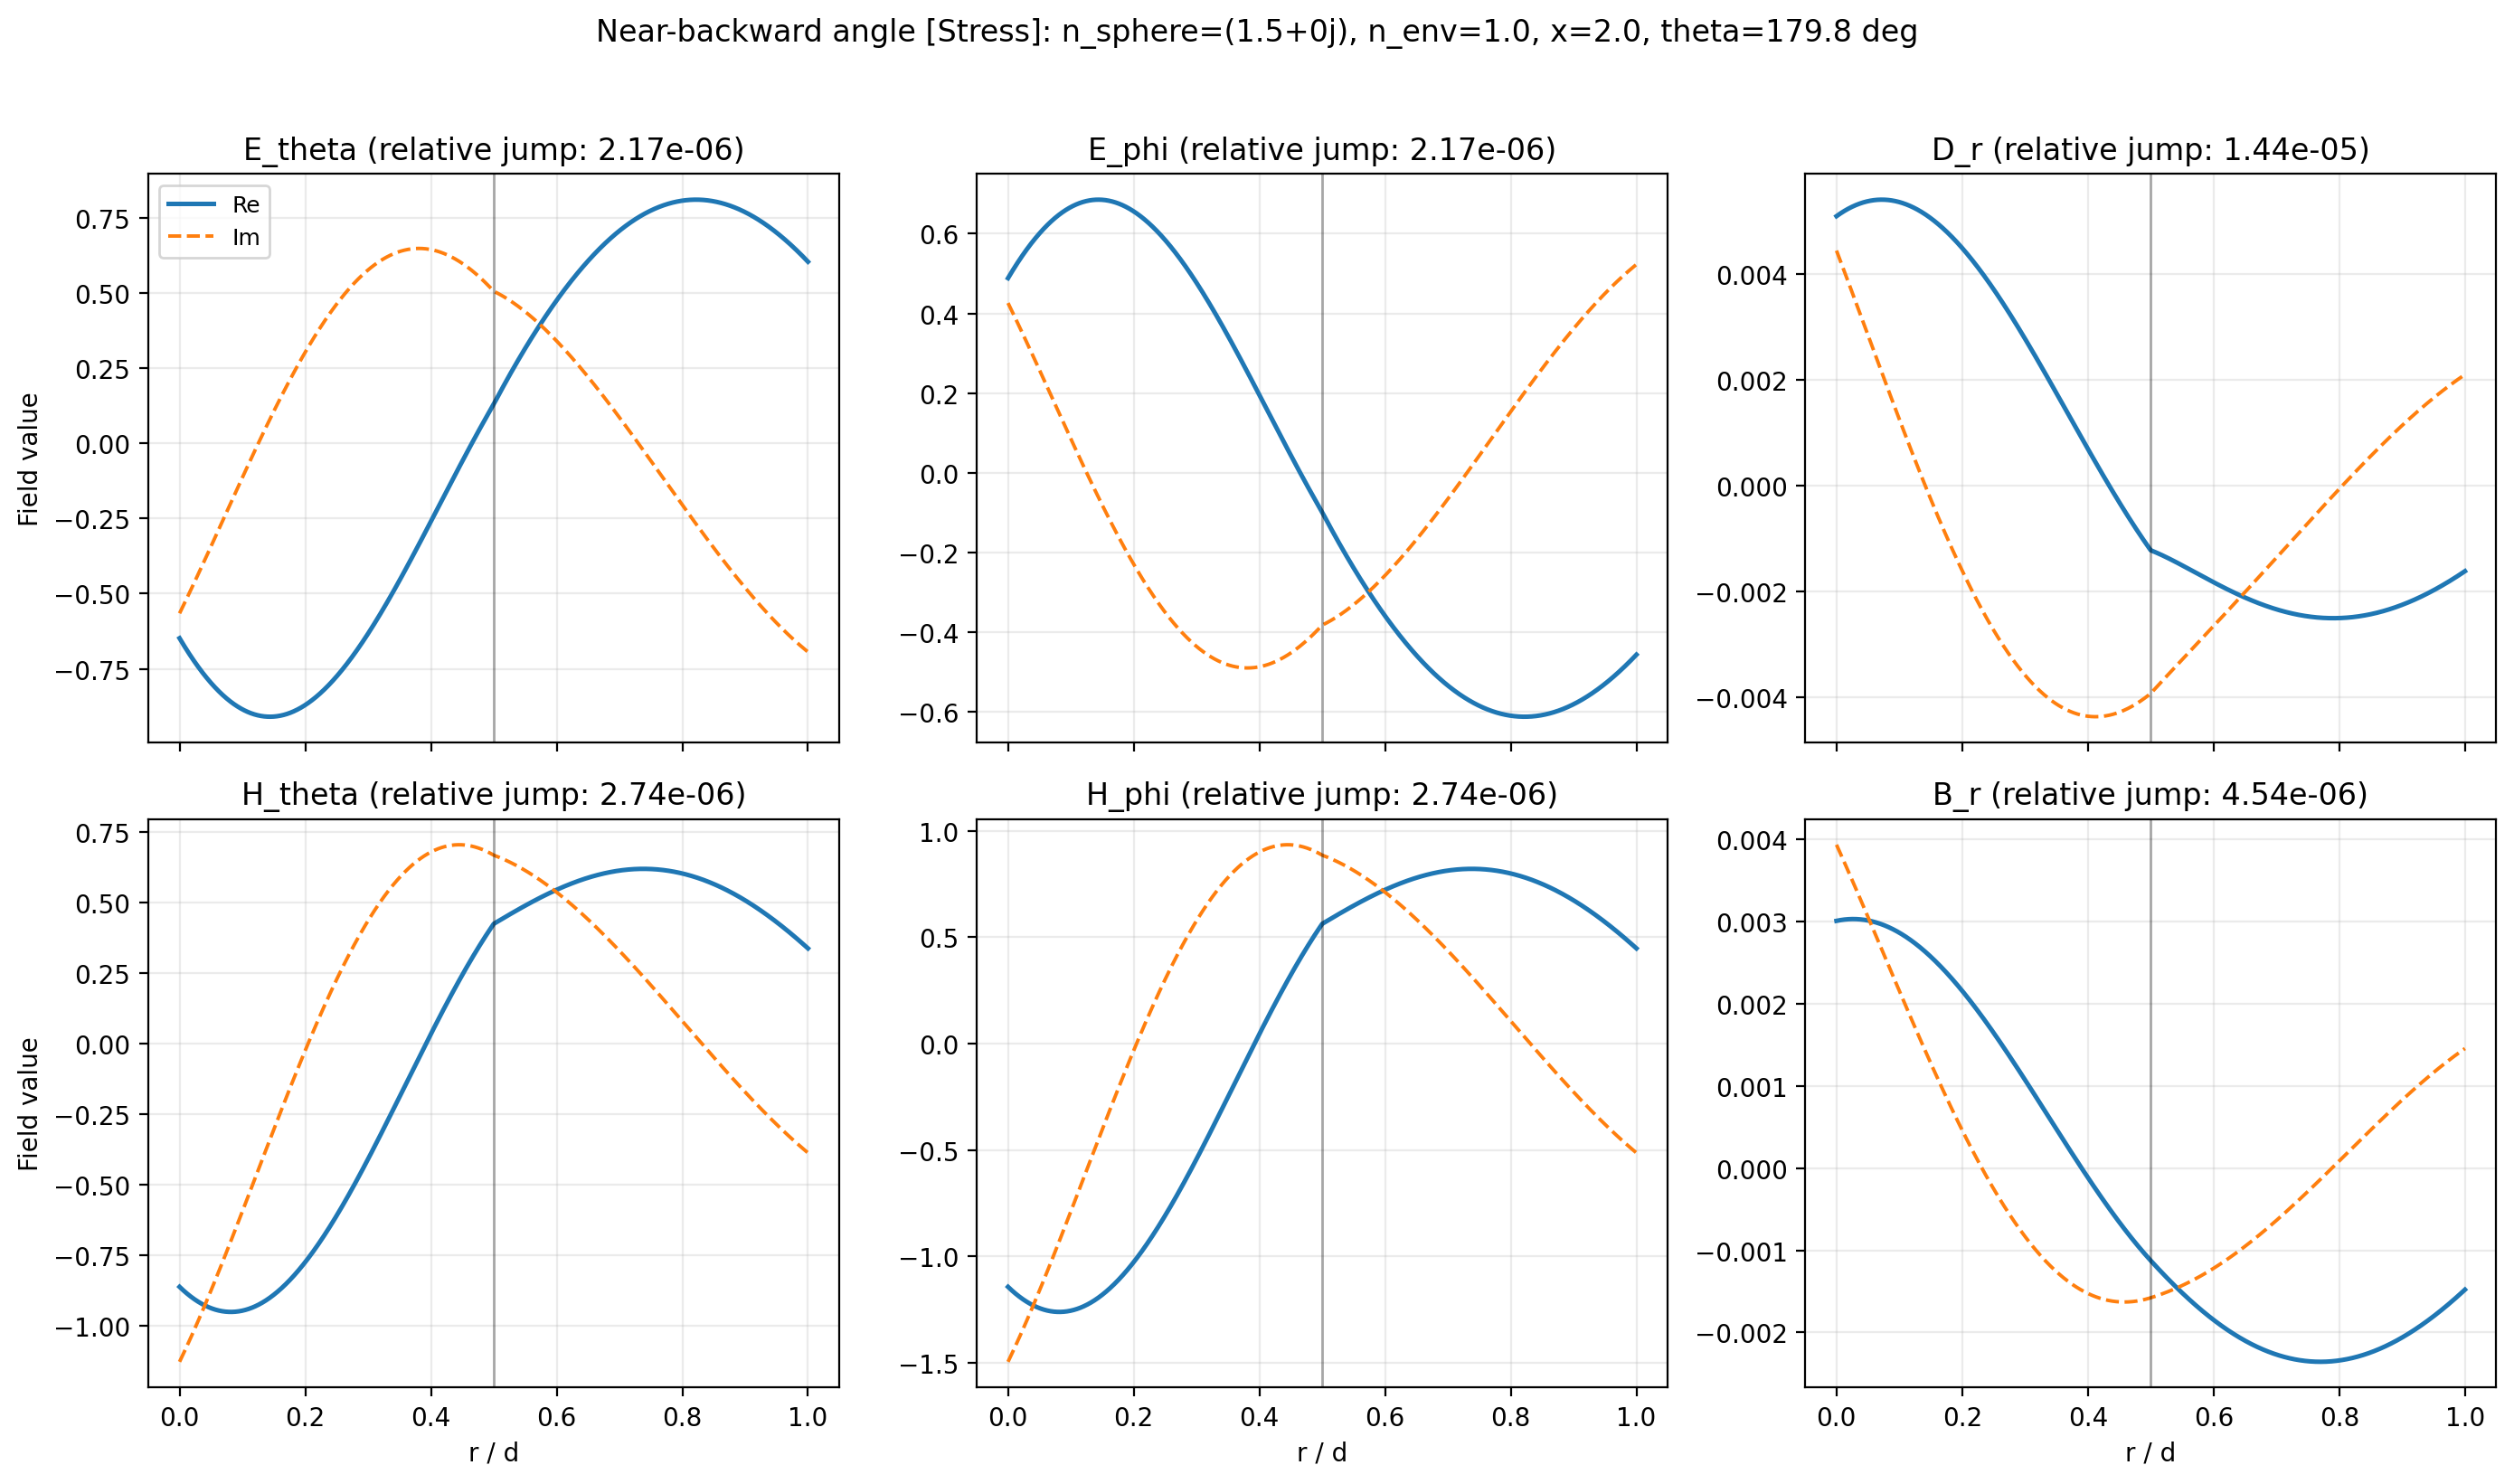

In [3]:
base_specs = [
    {'group': 'Base', 'label': 'Case 1', 'n_sphere': 1.5 + 0.0j, 'n_env': 1.0, 'x': 2.0},
    {'group': 'Base', 'label': 'Case 2', 'n_sphere': 1.5 + 0.0j, 'n_env': 1.3, 'x': 2.0},
    {'group': 'Base', 'label': 'Case 3', 'n_sphere': 1.5 - 0.1j, 'n_env': 1.0, 'x': 2.0},
]

stress_specs = [
    {
        'group': 'Stress',
        'label': 'Index-matched baseline',
        'n_sphere': 1.3 + 0.0j,
        'n_env': 1.3,
        'x': 2.0,
    },
    {
        'group': 'Stress',
        'label': 'High-contrast dielectric',
        'n_sphere': 2.5 + 0.0j,
        'n_env': 1.0,
        'x': 2.0,
    },
    {
        'group': 'Stress',
        'label': 'Rayleigh regime',
        'n_sphere': 1.5 + 0.0j,
        'n_env': 1.0,
        'x': 0.3,
    },
    {
        'group': 'Stress',
        'label': 'Multimode regime',
        'n_sphere': 1.5 + 0.0j,
        'n_env': 1.0,
        'x': 8.0,
    },
    {
        'group': 'Stress',
        'label': 'Near-forward angle',
        'n_sphere': 1.5 + 0.0j,
        'n_env': 1.0,
        'x': 2.0,
        'theta_deg': 0.2,
    },
    {
        'group': 'Stress',
        'label': 'Near-backward angle',
        'n_sphere': 1.5 + 0.0j,
        'n_env': 1.0,
        'x': 2.0,
        'theta_deg': 179.8,
    },
]

all_specs = base_specs + stress_specs

results = []
for spec in all_specs:
    case = compute_case(
        n_sphere=spec['n_sphere'],
        n_env=spec['n_env'],
        x=spec.get('x', 2.0),
        theta_deg=spec.get('theta_deg', 70.0),
        phi_deg=spec.get('phi_deg', 37.0),
        npts=spec.get('npts', 3001),
    )
    case['label'] = spec['label']
    case['group'] = spec['group']
    results.append(case)

    plot_case(case)
    plt.show()



In [4]:
names = ['E_theta', 'E_phi', 'D_r', 'H_theta', 'H_phi', 'B_r']

for case in results:
    print(
        f"\n[{case['group']}] {case['label']}: "
        f"n_sphere={case['n_sphere']}, n_env={case['n_env']}, "
        f"x={case['x']}, theta={case['theta_deg']:.1f} deg, "
        f"lambda0={case['lambda0']:.6f}"
    )
    for name in names:
        print(f"  {name:8s} relative jump near r=d/2: {case['jumps'][name]:.3e}")
    max_jump = max(case['jumps'].values())
    print(f"  {'max_jump':8s} relative jump near r=d/2: {max_jump:.3e}")




[Base] Case 1: n_sphere=(1.5+0j), n_env=1.0, x=2.0, theta=70.0 deg, lambda0=1.570796
  E_theta  relative jump near r=d/2: 6.251e-06
  E_phi    relative jump near r=d/2: 1.126e-06
  D_r      relative jump near r=d/2: 2.990e-06
  H_theta  relative jump near r=d/2: 3.797e-06
  H_phi    relative jump near r=d/2: 3.291e-07
  B_r      relative jump near r=d/2: 2.253e-06
  max_jump relative jump near r=d/2: 6.251e-06

[Base] Case 2: n_sphere=(1.5+0j), n_env=1.3, x=2.0, theta=70.0 deg, lambda0=2.042035
  E_theta  relative jump near r=d/2: 2.261e-06
  E_phi    relative jump near r=d/2: 1.766e-08
  D_r      relative jump near r=d/2: 1.354e-06
  H_theta  relative jump near r=d/2: 1.829e-06
  H_phi    relative jump near r=d/2: 5.263e-07
  B_r      relative jump near r=d/2: 6.856e-07
  max_jump relative jump near r=d/2: 2.261e-06

[Base] Case 3: n_sphere=(1.5-0.1j), n_env=1.0, x=2.0, theta=70.0 deg, lambda0=1.570796
  E_theta  relative jump near r=d/2: 7.908e-06
  E_phi    relative jump near r=d/2